## INTRODUCTION
The reason we decided to build a transformer from scratch is because we were curious. we wanted to understand what’s really happening behind the scenes in this architecture that has taken the world by storm. This notebook is not about optimizing performance or building a high-accuracy model. The main goal is to understand the intuition behind the architecture and try to implement it in code.

We used the paper “Attention Is All You Need” by Google as my main reference and chose the task of translating from Burmese to English. For that, I used the mutiyama/alt dataset from Hugging Face. (add link)

We have always been fascinated by how a model that is probabilistic in nature can perform so accurately. How do these models turn tokens into vectors? And how do they learn to understand the meaning behind them?

We won’t claim we fully understand every detail that happens inside a transformer, but by the time we finished this, we walked away with a lot of clarity and some important takeaways.

To give a quick introduction, transformers are sequence processing models that are considered a successor to RNNs, mainly because they solve two major problems. First, RNNs process each token one at a time in sequence, which slows down training, and they do the same during inference too. Transformers, on the other hand, process the entire sequence in parallel, making training significantly faster especially on GPUs.

Second, RNNs tend to forget earlier tokens as the sequence grows longer. Transformers solve this by introducing global attention, where every token can attend to every other token. This means even distant context can still be accessed easily. Transformers also handle vanishing gradients much better thanks to residual connections and normalization.

A transformer is built using two main blocks: the encoder and the decoder. The encoder is responsible for taking the input and encoding it into a useful representation you can think of this as turning each token (let’s just say “word” for simplicity) into a list of numbers that somehow carries its meaning. Like, when the model sees “cat,” the numbers it encodes carry the concept of a cat it’s kind of magical. This ability to represent information meaningfully is what makes transformers so powerful. to make it simple and to help us understand better lets say that the the token cat will be represented as [1,45,56,74,35,....65,78] basically a list of numbers.



Each encoder block contains a multi-head attention sublayer and a feed-forward sublayer (don’t worry if that sounds confusing, we’ll explain all of it step-by-step), with normalization and residual connections wrapped around them.

The decoder takes the encoded representation from the encoder along with the target output sequence (what it’s trying to predict) and tries to generate the correct output one token at a time. This is where the real magic happens — the model learns how different tokens relate to each other and figures out which ones to focus on, given what it has seen so far. It predicts the next token using just the previous tokens.

This is a high-level overview of what transformers do. In the rest of this notebook, we’ll break down each block in detail and try to really understand what’s happening under the hood. So let’s dive into the code and get our hands dirty.

## TRANSFORMER IMPLEMENTATION

In [313]:
from datasets import load_dataset
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from pathlib import Path

### EMBEDDING LAYER

In [233]:

class InputEmbeddings(nn.Module): #dmodel of 256 should be okay since we are doing this for educational purposes
    def __init__(self, d_model: int, vocab_size: int):
        
        super().__init__()
        self.d_model=d_model
        self.vocab_size=vocab_size
        self.embedding=nn.Embedding(vocab_size,d_model)
    def forward(self,x):
        return self.embedding(x) * math.sqrt(self.d_model)
        



We use an embedding layer to convert each input token into a vector of size d_model. This d_model is a key parameter that determines the model's capacity to represent information. it remains constant throughout all the layers and essentially determines the size of the embedding vector for each token. In the original paper they used d_model of 512. That means each token is represented as a vector of size 512. This parameter directly impacts the models complexity, larger values provide more representational power but they require more computational power and memory. Since we have limited hardware capacity at our disposal we are going to choose the d_model as 256, to keep things less complex and memory efficient for us to run it on our potato devices! After each input token is converted into an embedding it is multiplied by the square root of d_model. This is to ensure numerical stability, without this scaling, the values going into the attention mechanism might be too small, which can lead to vanishing gradients or poor learning early on. This scaling makes the initialization more balanced and helps the model learn better.

### POSITIONAL ENCODING

In [205]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model: int, seq_len: int, dropout: float) -> None: 
        super().__init__()
        self.d_model=d_model
        self.seq_len=seq_len
        self.dropout=nn.Dropout(dropout)

        #create a matrix of shape(seq_len, d_model) each vector is of the size d_model
        pe=torch.zeros(seq_len,d_model)
        position=torch.arange(0,seq_len,dtype=torch.float).unsqueeze(1) # vector of shape (seq_len,1)
        div_term= torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0) / d_model)) #calculating in log space for numerical stability
        pe[:,0::2]=torch.sin(position * div_term)
        pe[:,1::2]=torch.cos(position * div_term)

        pe=pe.unsqueeze(0) #(1,seq_len,d_model) to add batch dimension
        self.register_buffer('pe',pe) #register buffer is used to register the pe matrix as a buffer, it is not a parameter of the model and is not updated during backpropagation

    
    def forward(self,x):
        x=x+self.pe[:,:x.shape[1],:].requires_grad_(False) #(batch_size,seq_len,d_model)
        return self.dropout(x)
    

        

Each token gets an embedding vector from the InputEmbeddings layer But that alone doesn’t tell the model anything about the position of that token in the sequence. So to tackle this we generate a fixed, non learnable matrix using sine and cosine functions. Sine is applied to even dimensions and cosine to odd dimensions of the vector. The idea is that each position in the sequence gets a unique vector that helps the model understand token positions and their relative distances.

The formulas used to compute the positional encodings are:

$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right), \quad
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{\text{model}}}}}\right)
$$

 In our case, we’re translating from **Burmese (character-level)** to **English (word-level)**, so we use **different sequence lengths** for the source and target languages:

- **English**:
  - Based on our dataset, 95% of the English sentences have around 55 tokens (after splitting by spaces).
  - So, we set the target sequence length** to 55.
  - This means the positional encoding matrix for the decoder will have the shape:  
    ```
    (1, 55, d_model)
    ```

- **Burmese**:
  - Since Burmese is tokenized at the **character level**, the sequence length is longer.
  - We calculate and set a longer **source sequence length** (e.g., `500`) based on the **character distribution** in the source data.
  - This results in a **positional encoding matrix** for the encoder of shape:
    ```
    (1, 500, d_model)
    ```

The positional encodings are added to the embeddings before being passed into the model. This gives each token: **Semantic meaning** from the embeddings and **Positional context** from the encodings.

And similarly, for Burmese, we calculate and set a longer sequence length based on the character distribution in the source data.

The positional encodings are added to the embeddings before passing into the model, giving each token both semantic meaning (from the embeddings) and positional information (from the encodings).


### LAYER NORMALIZATION

In [222]:
class LayerNormalization(nn.Module):
    def __init__(self, features: int, eps: float = 10**-6) -> None:
        super().__init__()
        self.eps=eps #epsilon is used to avoid division by zero and to ensure numerical stability
        self.alpha=nn.Parameter(torch.ones(features)) #multiplicative factor
        self.bias=nn.Parameter(torch.zeros(features)) #additive factor


    def forward(self, x):
        mean=x.mean(dim=-1,keepdim=True) #mean of the last dimension
        std= x.std(dim=-1,keepdim=True)
        return self.alpha * (x-mean)/(std+self.eps) + self.bias #we use the formula in the paper Layer Normalization Jimmy Lei Ba





Layer Normalization each normalizes the token along with d_model dimension at each position in the sequence. 
it calculates the mean and standard deviation along the last dimension and normalizes to zero mean and variance
unlike batch normalization which normalizes across the batch, LayerNorm normalizes each token individually
and then it adds a learnable scale (alpha) and shift (bias), which allows the model to rescale the normalized values if needed.

### FEED FORWARD BLOCK

In [45]:
class FeedForwardBlock(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float)-> None:
        super().__init__()
        self.linear_1=nn.Linear(d_model,d_ff) #shape of the w1 matrix is d_ff,d_model pytorch creates a weight matrix of shape (out_features,in_features) and adds bias automatically
        self.dropout=nn.Dropout(dropout)
        self.linear_2=nn.Linear(d_ff,d_model)
    
    def forward(self,x):
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))



This is the feed forward block used both in the encoder layer and decoder layer.The feed forward block increases the model's learning capacity by expanding the last dimension. nn.linear applies a linear transformation y= xW^T + b. the number of hidden neurons in the network is given by d_ff and it is usually 4 times the d_model so our d_ff would be 1024 since d_model=256.The idea is to temporarily increase the model’s representational capacity by expanding the last dimension (d_model) into a much larger hidden size (d_ff), then squashing it back down.So if our input shape is (batch_size, seq_len, d_model) → let’s say (32, 500, 256) for Burmese, the first linear layer projects each token’s embedding from 256 → 1024 → output becomes (32, 500, 1024), which kind of means you are learning 1024 new features from the original 256. Then we apply Relu activation and dropout to sharpen the signals of only those activations that are important dropout  means we randomly set a few of the outputs to zero with probability p. Finally, the second linear layer maps it back down from 1024 → 256, so we’re back to the original shape (32, 500, 256). 

This is the feed forward block used in both the encoder and decoder layers of the Transformer.
The goal of this block is to temporarily expand the model’s learning capacity by increasing the last dimension (d_model) to a larger hidden size (d_ff) and then bringing it back to the original size.

nn.Linear applies a simple linear transformation of the form:
$$
y = xW^\top + b
$$

Typically, d_ff is set to 4 × d_model. In our case:
	d_model = 256
	d_ff = 1024


- Let’s break that down what's happening:
	-	Our input is shaped (batch_size, seq_len, d_model) = (32, 500, 256)
	-	The first Linear layer expands the last dimension from 256 to 1024 which means 1024 new features to	learn from the initial 256
	-	This means we’re allowing the model to learn 1024 new features for each token
	-	Next, we apply a ReLU activation followed by Dropout
	-	ReLU introduces non-linearity, it also helps us to filter out noise
	-	Dropout randomly sets some outputs to 0 with a certain probability p, helping with regularization
	-	Finally, the second Linear layer projects it back down from 1024 to 256, so the final shape is back to (32, 500, 256)

The idea is to temporarily increase the model’s representational capacity by expanding the last dimension (d_model) into a much larger hidden size (d_ff), then squashing it back down to fit the original shape. 


### MLUTI HEAD ATTENTION(self attention) BLOCK

In [46]:
class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: float)-> None:
        super().__init__()
        self.d_model=d_model
        self.h=h
        self.d_k=d_model//h #we have to make sure that d_model is divisible by h. h is the number of heads.
        self.w_q=nn.Linear(d_model,d_model)
        self.w_k=nn.Linear(d_model,d_model)
        self.w_v=nn.Linear(d_model,d_model)
        self.w_o=nn.Linear(d_model,d_model)
        self.dropout=nn.Dropout(dropout)

    @staticmethod
    def attention(query,key,value,mask,dropout: nn.Module):
        d_k=query.shape[-1]


        attention_scores=(query @ key.transpose(-2,-1))/math.sqrt(d_k)  #(batch_size,h,seq_len,d_k) --> (batch_size,h,seq_len,seq_len)

        if mask is not None:
            attention_scores.masked_fill_(mask==0,-1e9)
        attention_scores=attention_scores.softmax(dim=-1) #(batch_size,h,seq_len,seq_len)

        if dropout is not None:
            attention_scores=dropout(attention_scores)
        return (attention_scores @ value), attention_scores #attention_scores for visualization
    
    def forward(self,q,k,v,mask): #we use mask basically to avoid specific tokens interacting with each other. we do this before applying softmax
        query=self.w_q(q) #(batch_size,seq_len,d_model) --> (batch_size,seq_len,d_model)
        key = self.w_k(k) #(batch_size,seq_len,d_model) --> (batch_size,seq_len,d_model)
        value = self.w_v(v) #(batch_size,seq_len,d_model) --> (batch_size,seq_len,d_model)

        query=query.view(query.shape[0],query.shape[1],self.h,self.d_k).transpose(1,2) #(batch_size,seq_len,d_model) --> (batch_size,seq_len,h,d_k) --> (batch_size, h , seq_len, d_k)
        key=key.view(key.shape[0],key.shape[1],self.h,self.d_k).transpose(1,2)
        value=value.view(value.shape[0],value.shape[1],self.h,self.d_k).transpose(1,2)

        # (batch_size, h , seq_len, d_k) --> (batch_size, seq_len, h, d_k) --> (batch_size, seq_len, d_model)
        x, self.attention_scores=MultiHeadAttentionBlock.attention(query,key,value,mask,self.dropout)
        x=x.transpose(1,2).contiguous().view(x.shape[0],-1,self.h * self.d_k) #h*dk=d_model because d_k = d_model/h
        # (batch_size, seq_len, d_model) --> (batch_size, seq_len, d_model)
        return self.w_o(x)



Now we’re deep inside transformer territory, this is where things get really interesting! In the encoder we perform what's called a **self-attention** where we calculate how much each token should focus on every other token in the sequence. In simpler words, the model learns how important token *i* is with respect to token *j* in the same sequence. To do this we create 3 weight matrices Query(Q), Key(K) and Value(V)  of shape `[d_model,d_model]`. We multiply the input with each of their respective weight matrices to obtain three sperate projections:
- `Q = x @ W_q`
- `K = x @ W_k`
- `V = x @ W_v`

All of them have the shape:  

$$
(\text{batch\_size}, \text{seq\_len}, \text{d\_model}) = (4, 500, 256)
$$

Each of these projections captures different roles,the Query is what we are looking for. Key is what we are comparing against and the Value is the actual information we want to retrieve. Next we split the d_model dimension of each of these matrices into `h` smaller heads. We have to make sure that d_model is completely divisible by the number of heads(h) we use for distribituing the representation evenly.The paper used 8 heads but to keep it simple and resource efficient we are going to be using only 4 heads. Splitting the embedding into multiple heads allows the model to look at the same input from different perspectives. Each head learns different patterns of attention. For example, one head might learn syntax like subject–verb relationships, while another head might focus on capturing semantic meaning

After reshaping and transposing, the shape of each becomes:  
$$
(\text{batch\_size}, h, \text{seq\_len}, d_k) = (32, 4, 500, 64)
$$

Each head now processes the full sequence, but only a slice of the embedding space.

We calculate attention scores using:

$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{Q K^\top}{\sqrt{d_k}}\right)V
$$

This gives us attention scores of shape:  
$$
(\text{batch\_size}, h, \text{seq\_len}, \text{seq\_len})
$$

This matrix tells us how much attention each token should pay to every other token. For example, consider the sentence:

 `"The cat sat on the mat"`

When processing the token `"sat"`, the model might pay more attention to the token `"cat"` to understand who is doing the action. So, the attention score between `"sat"` and `"cat"` will be higher than between `"sat"` and unrelated words like `"the"`. This mechanism allows tokens forming a single logical unit like a word to have a stronger mututal attention score.What’s amazing is that the model learns these relationships without any explicit linguistic rules. We also apply a mask to stop the model from focusing on irrelevant tokens like padding. This is done by setting those attention scores to `-1e9`, so after softmax, their probabilities are close to zero, effectively ignoring them.

Once each head produces its output, we concatenate them along the embedding dimension:
$$
(\text{batch\_size}, h, \text{seq\_len}, d_k) \Rightarrow (\text{batch\_size}, \text{seq\_len}, h \cdot d_k) = (\text{batch\_size}, \text{seq\_len}, d_model)
$$

We then pass this through one final linear layer `w_o`. This step combines the outputs from all heads into a single, unified embedding so the model can continue processing it in the same vector space as the input.This is where the model starts building rich contextual embeddings. EEach token's vector now holds information about its relationship with every other token in the sentence. This part feels like the true core of transformers. How it encodes context and "learns to focus" is very fascinating. Like, how did someone even come up with this?







tra

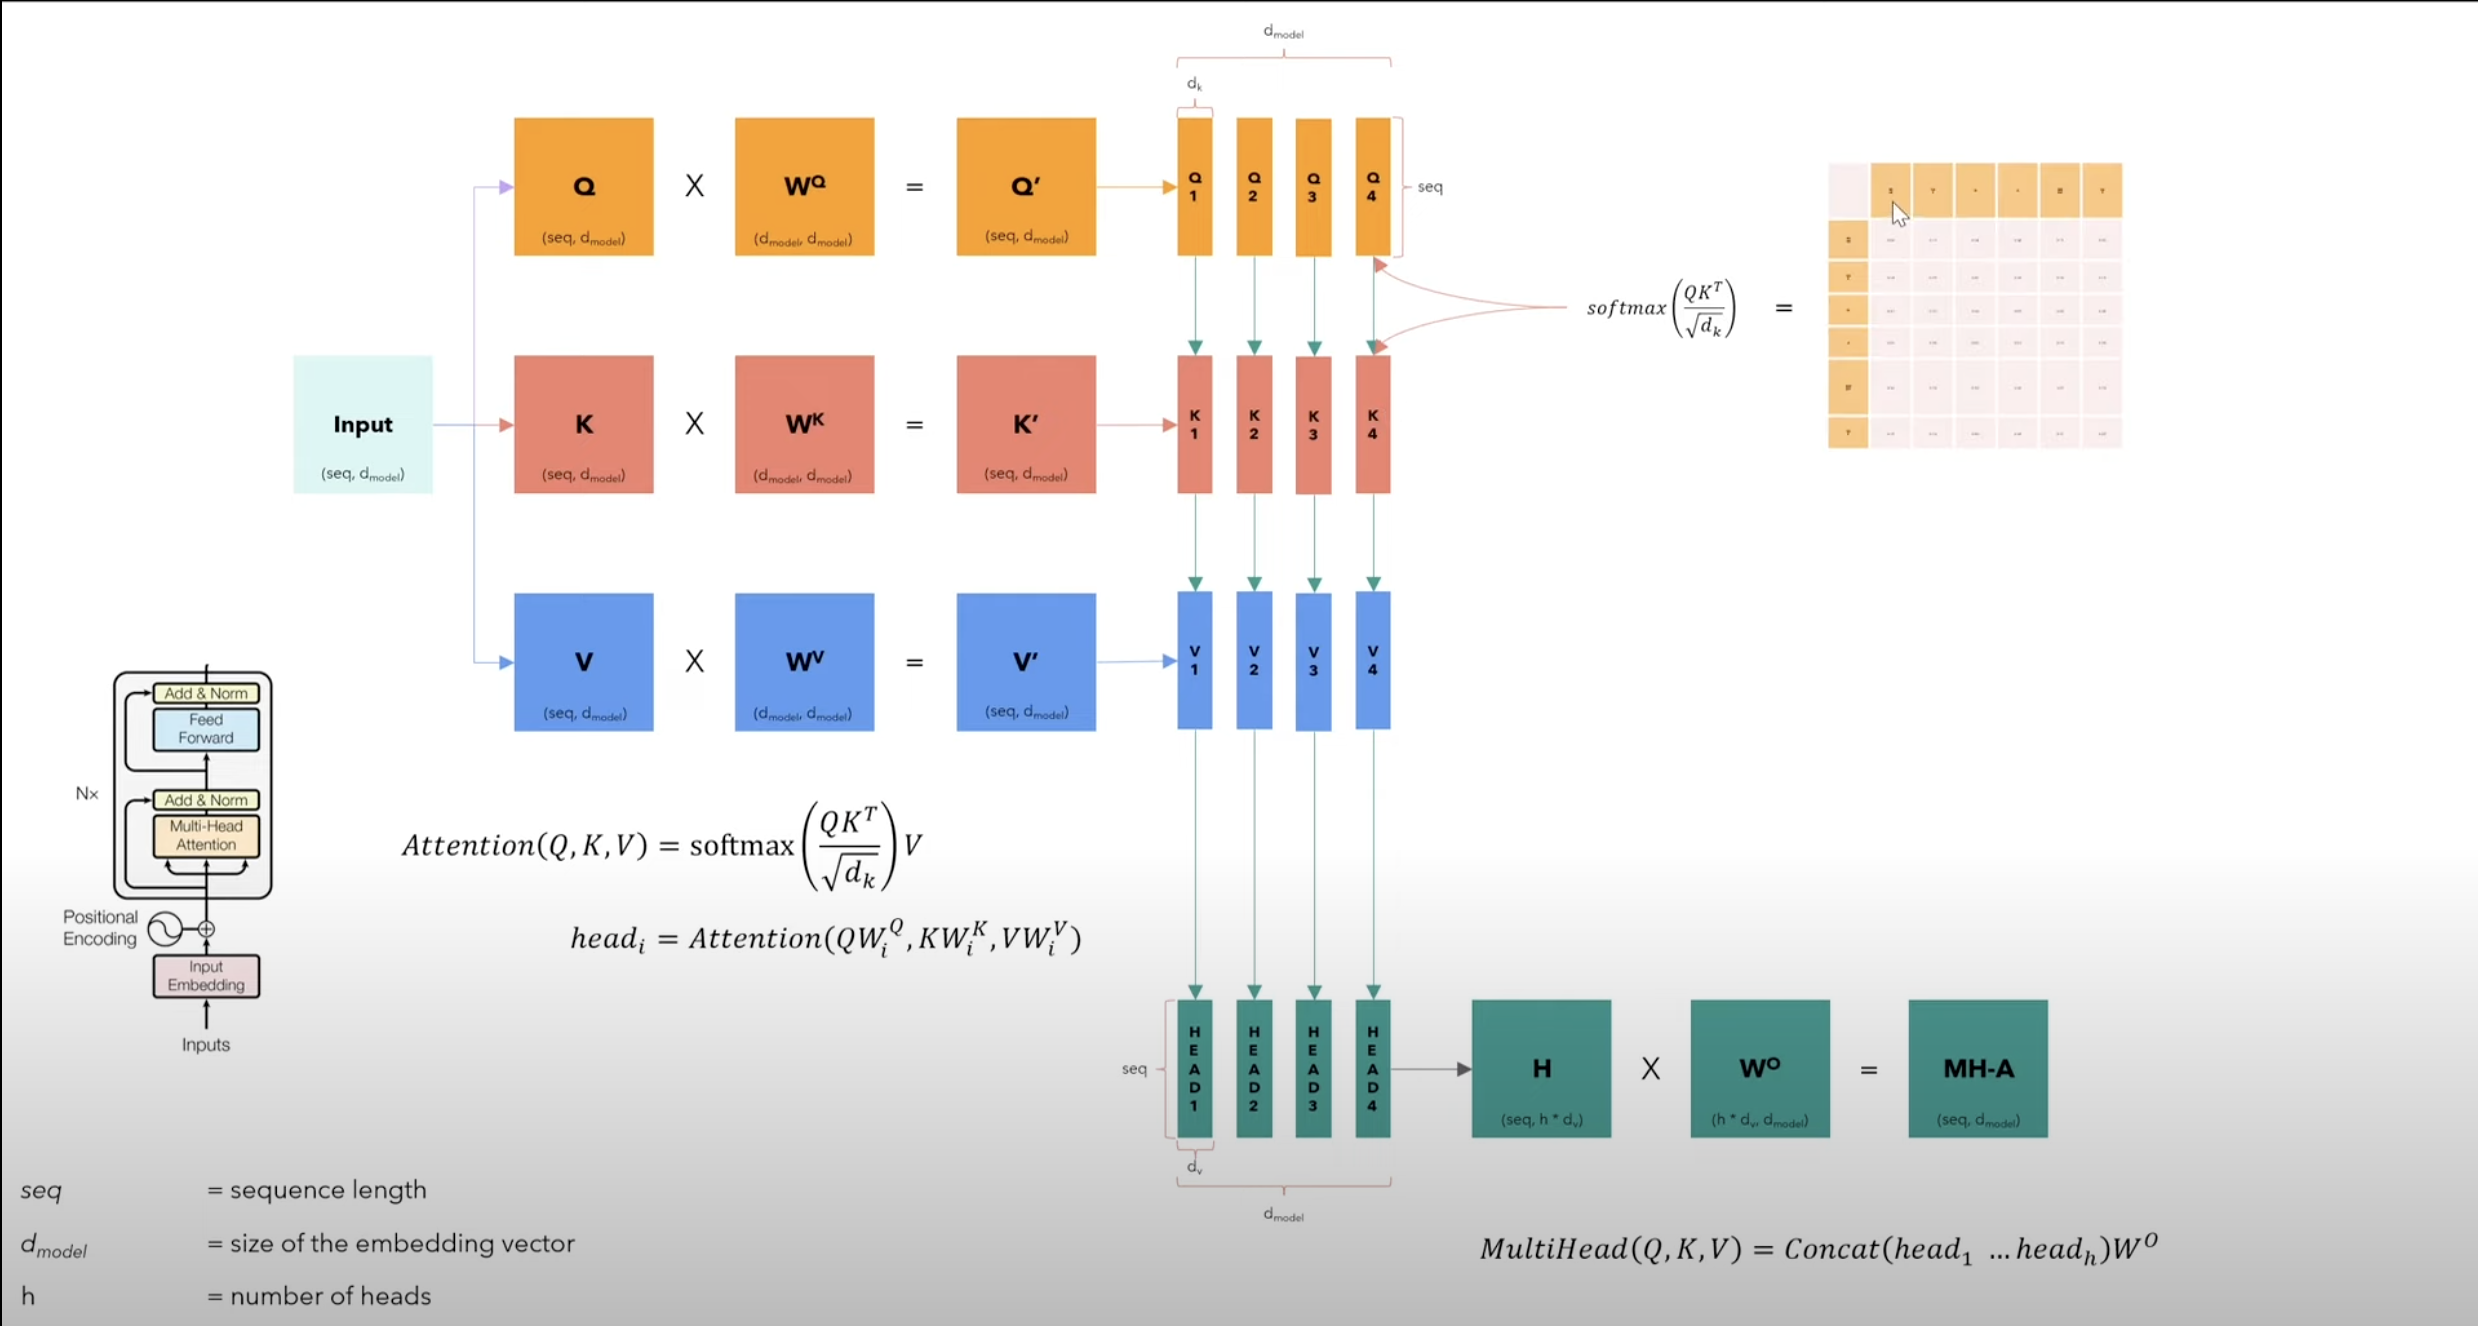

In [297]:
from IPython.display import Image
Image(data="attention_screenshot.png")

[umar jamil]: https://youtu.be/ISNdQcPhsts?t=1735
Image credits: [umar jamil]

### Residual Layer

In [211]:
class ResidualConnection(nn.Module):

    def __init__(self,features: int,dropout: float)-> None:
        super().__init__()
        self.dropout=nn.Dropout(dropout)
        self.norm=LayerNormalization(features)

    def forward(self,x,sublayer: nn.Module):
        return x+self.dropout(sublayer(self.norm(x)))        

The residual layer adds the output of a layer back to its original input. In simple terms, it returns:
$$
output = x + sublayer(x)
$$
Here `x` is the input and `sublayer(x)` is the transformation applied (like Multi-Head Attention or Feed Forward block). In deep neural networks gradients can either vanish or explode, which makes the training unstable. A residual connection helps by preserving the original input signal, even if the sublayer starts with poor weight initialization.So even when learning is noisy, the model still retains the "raw" version of the input, allowing better gradient flow.In the original Transformer paper, the residual block was used like this:
$$
LayerNorm(x + sublayer(x)) ⟶  Post-Norm
$$

But more recent research shows that using Pre-Norm (applying LayerNorm before the sublayer) models are less sensitive to changes in learning rate, thus allowing for more aggressive training schedules which is given by

$$
x + (sublayer(LayerNorm(x)))  ⟶  Pre-Norm
$$
Pre-Norm ensures that the inputs going into the sublayer are always normalized, reducing the chances of exploding or vanishing activations.

reference for this [1] Ruibin Xiong, Yunchang Yang, Di He, Kai Zheng, Shuxin Zheng, Chen Xing, Huishuai Zhang, Yanyan Lan, Liwei Wang, Tie-Yan Liu, "On Layer Normalization in the Transformer Architecture", arxiv, 2020

### Encoder Block

In [215]:
class EncoderBlock(nn.Module):

    def __init__(self,features: int,self_attention_block: MultiHeadAttentionBlock,feed_forward_block: FeedForwardBlock,dropout: float) -> None:
        super().__init__()
        self.self_attention_block=self_attention_block
        self.feed_forward_block=feed_forward_block
        self.residual_connections=nn.ModuleList([ResidualConnection(features,dropout) for _ in range(2)])

    def forward(self,x,src_mask):
        x=self.residual_connections[0](x,lambda x: self.self_attention_block(x,x,x,src_mask))
        x=self.residual_connections[1](x,lambda x: self.feed_forward_block(x))
        return x


We can have `N` number of encoder blocks stacked sequntially one after the other to form our complete  encoder. 

Each encoder block contains:
- A Multi-Head Self-Attention sublayer
- A Feed Forward sublayer
- Two Residual Connections (one for each sublayer)



Let’s break down what happens inside a single encoder block:

1. The first residual connection:
   - Normalizes the input `x`
   - Passes it through self-attention (with query, key, and value all set to `x`)
   - Applies dropout for regularization
   - Adds the result back to the original `x`

2. The second residual connection:
   - Takes the output from step 1
   - Normalizes it
   - Passes it through the Feed Forward Network
   - Applies dropout
   - Adds the result back to its input



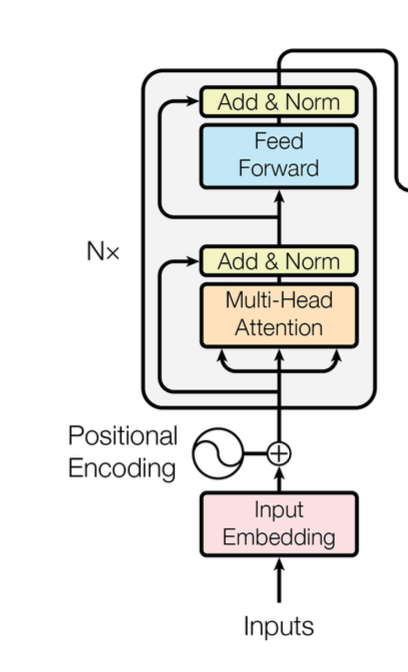

In [300]:
from IPython.display import Image
Image(data="encoder_block.png",width=300,height=300)

image source [attention is all you need]

In [210]:
class Encoder(nn.Module):
    def __init__(self, features: int, layers: nn.ModuleList)-> None:
        super().__init__()
        self.layers=layers #list of encoder blocks
        self.norm=LayerNormalization(features)
    
    def forward(self,x,mask):
        for layer in self.layers:
            x=layer(x,mask)
        return self.norm(x)

This is the full encoder module. it’s built by stacking multiple `EncoderBlock`s. We loop through each encoder block in the list and then normalise the output of the final encoder block to get the final output of the encoder which is of the shape 
$$
(\text{batch\_size}, \text{seq\_len}, d\_model) = (32, 500, 256)
$$
which is same as our input shape.
The encoder doesn’t just give you embeddings for the input vectors, it gives you vectors that understand how each of those characters relate to the others in the sentence. This is what makes Transformer encoders so powerful — they “bake in” context into each token’s vector. This output is later passed to the decoder, which uses it to generate the translation 

To solidify our understanding, let's take a simple example and walk through the encoder step by step.

We'll use the sentence:

`"Hi, how are you?"`

For demonstration, we assume the following model configuration:

- `d_model = 256`  
- `h = 4` (number of attention heads)  
- `seq_len = 30` (arbitrarily chosen for this example)  
- `N = 6` (number of encoder blocks)  
- `batch_size = 1` (for simplicity)

---

- Input Embedding
    - Assume it tokenizes to 5 tokens (with punctuation as separate tokens): ["Hi", ",", "how", "are", "you", "?"]  
    - We’ll pad this to seq_len = 30.
    - Each token is mapped to a learned vector of size d_model = 256
    - Input shape (before embedding): [batch_size, seq_len] -> [1,30]
    - Output shape (after embedding):  [batch_size, seq_len, d_model] -> [1,30,256]

- Positional Encoding

    - We add a fixed positional encoding to the token embeddings,this gives the model information about token order
    - Input shape: [batch_size, seq_len, d_model] -> [1,30,256]
    - Output shape: [batch_size, seq_len, d_model] -> [1,30,256]

- Encoder Block x 6

    - We now pass this through 6 identical encoder blocks.
    - Each encoder block consists of:

        - LayerNorm
        - Multi-Head Self-Attention
        - Dropout + Residual Add
        - LayerNorm
        - Feed Forward Network
        - Dropout + Residual Add

    - Inside attention, Q, K, V are all of shape: [batch_size, seq_len, d_model] -> [1,30,256]
    - After projection & splitting into 4 heads: [batch_size, h, seq_len, d_k] -> (1, 4, 30, 64) where d_k = d_model/h
    - Attention scores is of the shape [batch_size, h, seq_len, seq_len] -> (1,4,30,30)
    - Attention output (per head): [batch_size, h, seq_len, d_k] -> (1,4,30,64)
    - After concatenation: [batch_size,seq_len, d_model ] -> (1, 30, 256)
    - Apply layer normalisation and apply feed forward transformation
        - layer1 input: [batch_size,seq_len, d_model ] -> (1, 30, 256)
        - layer 1 output: [batch_size,seq_len, d_ff ] -> (1, 30, 1024)
        - layer 2 input: [batch_size,seq_len, d_ff ] -> (1, 30, 1024)
        - layer 2 output [batch_size,seq_len, d_model ] -> (1, 30, 256)
    - Output shape after each encoder block: [batch_size,seq_len, d_model ] -> (1, 30, 256)


   




### Decoder Block

In [214]:
class DecoderBlock(nn.Module):
    def __init__(self,features: int,self_attention_block: MultiHeadAttentionBlock,cross_attention_block: MultiHeadAttentionBlock,feed_forward_block: FeedForwardBlock,dropout: float)-> None:
        super().__init__()
        self.self_attention_block=self_attention_block
        self.cross_attention_block=cross_attention_block
        self.feed_forward_block=feed_forward_block
        self.residual_connections=nn.ModuleList(ResidualConnection(features,dropout) for _ in range(3))

    def forward(self,x,encoder_output, src_mask, tgt_mask): #src mask and target mask because we are dealing with translation here and they have different sequences

        x=self.residual_connections[0](x,lambda x: self.self_attention_block(x,x,x,tgt_mask)) #mask of the decoder
        x=self.residual_connections[1](x,lambda x: self.cross_attention_block(x, encoder_output, encoder_output,src_mask)) #query from decoder, key and value from encoder hence the cross attention and the mask of the encoder
        x=self.residual_connections[2](x,lambda x: self.feed_forward_block(x))
        return x
    

Just like the encoder, we can have `N` number of decoder blocks stacked sequentially to form the full decoder.
Each decoder block contains:
- A Multi-Head Self-Attention sublayer  
- A Multi-Head Cross-Attention sublayer  
- A Feed Forward sublayer  
- Three Residual Connections (one for each sublayer)

1. The first residual connection:
   - Normalizes the input `x`
   - Passes it through self-attention (Query, Key, and Value all come from the decoder input `x`)
   - Applies dropout for regularization
   - Adds the result back to the original `x`
   - This self-attention is masked using the target mask to ensure the decoder cannot "see" future tokens during training. It helps the model predict the next word based only on what it has already seen.

2. The second residual connection:
   - Takes the output from the self-attention step
   - Normalizes it
   - Passes it through cross-attention (Query comes from the decoder, Key and Value comes from the encoder's output)
   - Applies dropout
   - Adds the result back to its input
   - Source mask is used in the encoder and again in the cross-attention step of the decoder this is to ignore padding tokens in the source.

3. The third residual connection:
   - Takes the output from cross-attention
   - Normalizes it
   - Passes it through the Feed Forward Network
   - Applies dropout
   - Adds the result back to its input
  



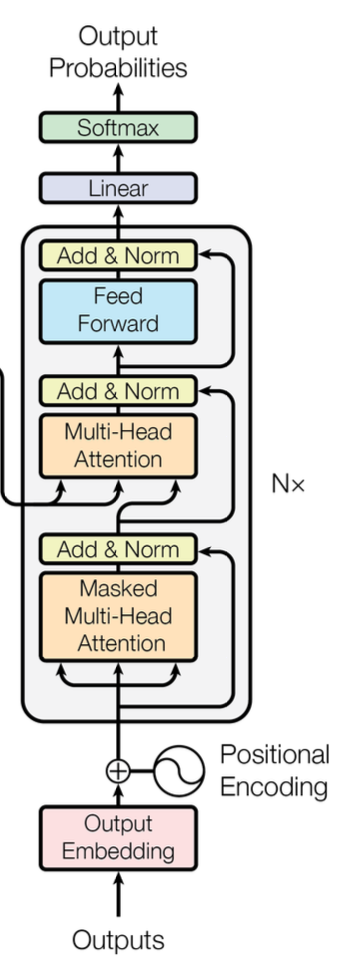

In [304]:
from IPython.display import Image
Image(data="decoder_block.png",width=200,height=200)

In [209]:
class Decoder(nn.Module):
    def __init__(self,features: int,layers: nn.ModuleList)-> None:
        super().__init__()
        self.layers=layers #list of decoder blocks
        self.norm=LayerNormalization(features)
    
    def forward(self,x,encoder_output,src_mask,tgt_mask):
        for layer in self.layers:
            x=layer(x,encoder_output,src_mask,tgt_mask)
        return self.norm(x)




This is the full decoder module. it’s built by stacking multiple `DecoderBlock`s. We loop through each decoder block in the list and then normalise the output of the final decoder block to get the final output of the decoder which is of the shape 
$$
(\text{batch\_size}, \text{seq\_len}, d\_model) = (4, 33, 256)
$$

The output of the decoder is a context aware representation of the target sequence generated so far based on what it has seen. In simple words, its like the decoder is saying based on everything i have seen so far nd from what i have learnt from the source sequence, here's what i think comes next in the target sequence.


### Linear Layer

In [52]:
class ProjectionLayer(nn.Module): 
    def __init__(self,d_model,vocab_size)-> None:
        super().__init__()
        self.proj=nn.Linear(d_model,vocab_size)

    def forward(self,x):
        return torch.log_softmax(self.proj(x),dim=-1)

This is the final layer of our model, It takes the decoder’s output which is in the shape: [batch_size, seq_len, d_model] and projects it into the shape: [batch_size, seq_len, vocab_size] where `vocab_size` is the size of the target language vocabulary. It maps each  vector (of size `d_model`) to a vector of vocabulary size of the target. essentially predicting which word should come next at each position in the output.we apply a `log_softmax` along the vocabulary dimension to obtain a log-probability distribution*over all possible tokens.

This output is used by the loss function (like `NLLLoss`) during training to compare predicted tokens with the actual ones.



Now lets try to combine the output from the encoder with this and have a walk through to solidify our understanding

Suppose our input to the encoder is "မင်္ဂလာပါ နေကောင်းလား"(Burmese) Which translates to "Hi, how are you?” in English. For the purpose of our demonstration, we are using a transformer with `d_model` = 256, `n` = 4 tgt_seq_len= 30, batch_size= 1, `N` =6 and we are using a word level tokenizer for english. The purpose of our on a higher level is to look at the encoder and figure out what it corresponding token it should generate in the target language based on the current inputs in the source language

The embedding and positional encoding steps remains the same as in the example shown for the encoder block

- We now pass this through 6 identical decoder blocks.
- Each decoder block consists of:

    - Masked Multi Head Self-Attention + Add & Norm
    - Maksed Multi Head Cross-Attention + Add & Norm
    - Feed Forward Network + Add & Norm
    - Dropout + Residual Add

- Masked self attention, Q, K, V are all of shape: [batch_size, seq_len, d_model] -> [1,30,256]
- Attention scores are given by [batch_size,seq_len,d_model] - > [1,30,256]
- In Cross attention Q is from decoder [1, 4, 33, 64], K and V comes from the encoder  [1, 4, 500, 64]
- The attention scores of cross attention is of the shape [1, 4, 33, 500]. This is where the decoder attends to the encoded Burmese sentence
- Feed forward layer transforms the shape from [1, 33, 256] → [1, 33, 1024] → [1, 33, 256]
- Output shape after each decoder block: [batch_size,seq_len, d_model ] -> (1, 30, 256)
- We apply the projection layer which transforms the shape into [batch_size, seq_len, tgt_vocab_size] - > [1,30, 10000] (assuming a vocabulary size of 10000). finally we apply log_sftmax to get the probability distribution of each token in vocabulary



In [53]:
class Transformer(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, src_embedding: InputEmbeddings, tgt_embedding: InputEmbeddings, src_pos_embedding: PositionalEncoding, tgt_pos_embedding: PositionalEncoding,projection_layer: ProjectionLayer)-> None:
        super().__init__()
        self.encoder=encoder
        self.decoder=decoder
        self.src_embedding=src_embedding
        self.tgt_embedding=tgt_embedding
        self.src_pos_embedding=src_pos_embedding
        self.tgt_pos_embedding=tgt_pos_embedding
        self.projection_layer=projection_layer
        

    def encode(self, src, src_mask):
        src=self.src_embedding(src)
        src=self.src_pos_embedding(src)
        return self.encoder(src, src_mask)
    
    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt=self.tgt_embedding(tgt)
        tgt=self.tgt_pos_embedding(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)
    
    def project(self,x):
        return self.projection_layer(x)

our final step is to create a combine all these different components mentioned above in a sequential manner to form the `Transformer` class.

Each Transformer model includes:
- `N` encoder and decoder layers
- A source embedding layer and positional encoding
- A target embedding layer and positional encoding
- A projection layer to map the decoder's output to the target vocabulary size

- `encode()`: Handles the encoding of the input (source) sequence using the embedding and encoder blocks.
- `decode()`: Processes the target sequence using the decoder, while attending to the encoder's output.
- `project()`: Maps the decoder's final output to a probability distribution over the target vocabulary using a linear projection layer.



In [221]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int=256, N: int=4, h: int =4, dropout: float=0.1, d_ff: int=1024)-> Transformer: #in the paper d_model=512, N=6, h=8,d_ff=2048
    
    src_embedding=InputEmbeddings(d_model, src_vocab_size)
    tgt_embedding=InputEmbeddings(d_model,tgt_vocab_size)
    src_pos_embedding=PositionalEncoding(d_model,src_seq_len,dropout)
    tgt_pos_embedding=PositionalEncoding(d_model,tgt_seq_len, dropout)

    encoder_blocks=[]
    for i in range(N):
        encoder_self_attention_block=MultiHeadAttentionBlock(d_model,h,dropout)
        feed_forward_block=FeedForwardBlock(d_model,d_ff,dropout)
        encoder_block=EncoderBlock(d_model,encoder_self_attention_block,feed_forward_block,dropout)
        encoder_blocks.append(encoder_block)

    decoder_blocks=[]
    for i in range(N):
        decoder_self_attention_block=MultiHeadAttentionBlock(d_model,h,dropout)
        decoder_cross_attention_block=MultiHeadAttentionBlock(d_model,h,dropout)
        feed_forward_block=FeedForwardBlock(d_model,d_ff,dropout)
        decoder_block=DecoderBlock(d_model,decoder_self_attention_block,decoder_cross_attention_block,feed_forward_block,dropout)
        decoder_blocks.append(decoder_block)
    
    encoder=Encoder(d_model,nn.ModuleList(encoder_blocks))
    decoder=Decoder(d_model,nn.ModuleList(decoder_blocks))

    projection_layer=ProjectionLayer(d_model,tgt_vocab_size)

    transformer=Transformer(encoder,decoder,src_embedding,tgt_embedding,src_pos_embedding,tgt_pos_embedding,projection_layer)

    for p in transformer.parameters():
        if p.dim()<2: continue
        nn.init.xavier_uniform_(p)
    
    return transformer

This function builds a Transformer model using the specified parameters .
Here is the breakdown:
- Input Embeddings for both source and target languages using `InputEmbeddings`
- Positional Encodings to inject token position information into each embedding.
- We then create `N` encoder blocks
- Similarly, we create `N` decoder blocks
- We use Xavier Uniform Initialization (`nn.init.xavier_uniform_`) on all model parameters with `dim ≥ 2`.  
This helps prevent issues like vanishing or exploding gradients and gives the model a better starting point to begin learning.

With this we can finally say that we have succesfully built our own transformer!! If you have made it this far you deserve a pat on the back! our focus was to implement the architecture succesfully.
Now lets think focus on our model configuration and dataset pipeline. The training and validation code is heavily inspired by the [github repo link]. 

Lets take a look at our dataset

In [306]:
from datasets import load_dataset
import math
import torch
import torch.nn as nn
ds = load_dataset("mutiyama/alt", "alt-parallel")
ds['train'][0]

{'SNT.URLID': '80188',
 'SNT.URLID.SNTID': '1',
 'url': 'http://en.wikinews.org/wiki/2007_Rugby_World_Cup:_Italy_31_-_5_Portugal',
 'translation': {'bg': 'ফ্রান্সের প্যারিসের পার্ক দি প্রিন্সেস-এ হওয়া ২০০৭-এর রাগবি বিশ্বকাপের পুল সি-তে ইটালি পর্তুগালকে ৩১-৫ গোলে হারিয়েছে।',
  'en': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.',
  'en_tok': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes , Paris , France .',
  'fil': 'Natalo ng Italya ang Portugal sa puntos na 31-5 sa Grupong C noong 2007 sa Pandaigdigang laro ng Ragbi sa Parc des Princes, Paris, France.',
  'hi': '2007 में फ़्रांस, पेरिस के पार्क डेस प्रिंसेस में हुए रग्बी विश्व कप के पूल C में इटली ने पुर्तगाल को 31-5 से हराया।',
  'id': 'Italia berhasil mengalahkan Portugal 31-5 di grup C dalam Piala Dunia Rugby 2007 di Parc des Princes, Paris, Perancis.',
  'ja': 'フランスのパリ、パルク・デ・プランスで行われた2007年ラグビーワールドカップのプールCで、イタリアは31対5でポルトガルを

We can see that the dataset we are using contains parallel translation across mutiple languages each sentence. Since our task is to translate from Burmese (`'my'`) to English (`'en'`), we only need those two languages from the `translation` field. so our first goal will be to  drop all the rows that doesnt have english or burmese translation keep only the relevant fields and drop the rest. The function given below does exalty the same and returns a train, test and validation dataset.

In [ ]:


# train_dataset, test_dataset, val_dataset= clean_dataset(ds)
def clean_dataset(dataset):
    train_dataset = dataset['train']
    test_dataset = dataset['test']
    val_dataset = dataset['validation']
    
    # Create new dataset structure with id and translation dictionary
    def restructure(example, idx):
        return {
            'id': idx,
            'translation': {
                'burmese': example['translation']['my'],
                'english': example['translation']['en']
            }
        }
    
    # Apply restructuring with indices
    train_dataset = train_dataset.map(
        restructure, with_indices=True
    ).remove_columns(['SNT.URLID', 'SNT.URLID.SNTID', 'url'])
    
    test_dataset = test_dataset.map(
        restructure, with_indices=True
    ).remove_columns([ 'SNT.URLID', 'SNT.URLID.SNTID', 'url'])
    
    val_dataset = val_dataset.map(
        restructure, with_indices=True
    ).remove_columns(['SNT.URLID', 'SNT.URLID.SNTID', 'url'])
    
    # Filter out rows with None values
    train_dataset = train_dataset.filter(
        lambda x: x['translation']['burmese'] is not None and x['translation']['english'] is not None
    )
    
    test_dataset = test_dataset.filter(
        lambda x: x['translation']['burmese'] is not None and x['translation']['english'] is not None
    )
    
    val_dataset = val_dataset.filter(
        lambda x: x['translation']['burmese'] is not None and x['translation']['english'] is not None
    )
    
    return train_dataset, test_dataset, val_dataset


train_dataset, test_dataset, val_dataset= clean_dataset(ds)



The next step is to decide on appropriate equence lengths for both the source (Burmese) and target (English) inputs.

We have two main strategies for this:

1. We could use the longest sentence in the dataset as our sequence length. However, this comes with a serious tradeoff:

    - Only a very small number of sequences are close to that max length.
    - Most sequences are much shorter, so padding everything to the max would waste a lot of memory and computation.
    - On limited hardware, this approach is inefficient and often impractical.
2. We can analyze the distribution of the sequence length across the dataset and choose a reasonable upper bound,t his means:
    - 95% of the sequences will fit within the selected length
    - Only the longest 5% will be truncated
    - This approach is more practical and balanced considering our constraints


Burmese character length statistics:
50th percentile: 177.0
75th percentile: 235.0
90th percentile: 303.0
95th percentile: 348.0
98th percentile: 410.0
99th percentile: 460.0

English word length statistics:
50th percentile: 21.0
75th percentile: 28.0
90th percentile: 36.0
95th percentile: 41.0
98th percentile: 48.0
99th percentile: 53.0


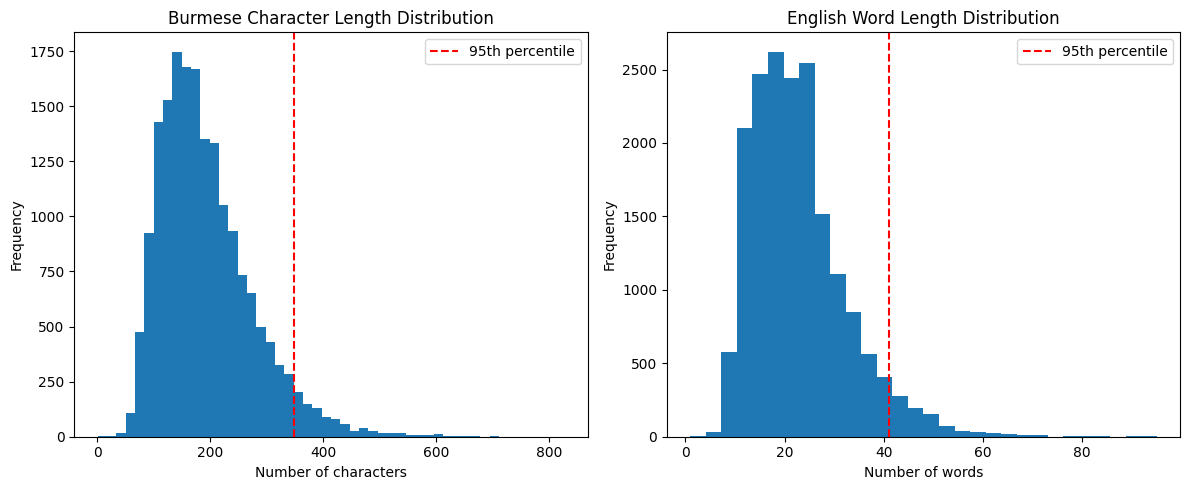

In [309]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

burmese_lengths = [len(list(item['translation']['burmese'])) for item in train_dataset]
# For English word lengths
english_lengths = [len(item['translation']['english'].split()) for item in train_dataset]

# Calculate percentiles
percentiles = [50, 75, 90, 95, 98, 99]
burmese_stats = {p: np.percentile(burmese_lengths, p) for p in percentiles}
english_stats = {p: np.percentile(english_lengths, p) for p in percentiles}

print("Burmese character length statistics:")
for p, v in burmese_stats.items():
    print(f"{p}th percentile: {v:.1f}")

print("\nEnglish word length statistics:")
for p, v in english_stats.items():
    print(f"{p}th percentile: {v:.1f}")

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(burmese_lengths, bins=50)
plt.title('Burmese Character Length Distribution')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.axvline(burmese_stats[95], color='r', linestyle='--', label='95th percentile')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(english_lengths, bins=30)
plt.title('English Word Length Distribution')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.axvline(english_stats[95], color='r', linestyle='--', label='95th percentile')
plt.legend()

plt.tight_layout()
plt.show()

We are using character level tokenizer for Burmese because burmeses is a language without very well defined word boundaries which makes word level tokenization inefficient. so each character in the sequence will be considered a token. For English we are using a word level tokenizer where each word is treated as a token.
Based on the length distribution plots and percentile statistics, 
- We set the source sequence length (Burmese) to 355
  - This accounts for up to 348 characters (95th percentile)  
  - Plus room for `[SOS]` and `[EOS]` tokens (start of sentence and end of sentence)
- We set the target sequence length (english) to 45:
  - This covers up to 45 words (95th percentile)  
  - Again, leaving space for special tokens  

In [188]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace, CharDelimiterSplit, PreTokenizer, Split
from tokenizers.trainers import WordLevelTrainer
from pathlib import Path



def create_english_tokenizer(dataset,config):
    tokenizer_path=Path(config['tokenizer_file'].format('en'))
    if not Path.exists(tokenizer_path):
        tokenizer=Tokenizer(WordLevel(unk_token='[UNK]'))
        tokenizer.pre_tokenizer=Whitespace()
        trainer=WordLevelTrainer(special_tokens=['[PAD]','[SOS]','[EOS]','[UNK]'],min_frequency=2,vocab_size=10000)
        english_texts = (item['translation']['english'] for item in dataset)
        tokenizer.train_from_iterator(english_texts,trainer,length=len(dataset))
        tokenizer.save('tokenizer_en')
    else:
        tokenizer=Tokenizer.from_file(str(tokenizer_path))
    return tokenizer
 
def create_burmese_tokenizer(dataset,config):
    tokenizer_path=Path(config['tokenizer_file'].format('my'))
    if not Path.exists(tokenizer_path):
        tokenizer=Tokenizer(WordLevel(unk_token='[UNK]'))
        tokenizer.pre_tokenizer = Split(pattern="", behavior="isolated")
        trainer=WordLevelTrainer(special_tokens=['[PAD]','[SOS]','[EOS]','[UNK]'],min_frequency=2,vocab_size=2000)
        burmese_texts = (item['translation']['burmese'] for item in dataset)
        tokenizer.train_from_iterator(burmese_texts,trainer,length=len(dataset))
        tokenizer.save('tokenizer_my')
    else:
        tokenizer=Tokenizer.from_file(str(tokenizer_path))
    return tokenizer



Here we are creating two tokenizers one for source and one for target. and for each of them we are adding ['[PAD]','[SOS]','[EOS]','[UNK]'] these as the special tokens where PAD is the padding token, SOS is the start of sentence token EOS is the end of sentence token and UNK is unknown token which is used when the model model encounters a token thats not there in its vocaabulary. we compute the embeddings once and save it to the 
respective tokenizer files

We define two separate tokenizers — one for the source (Burmese) and one for the target (English), because the tokenization strategies for these languages are fundamentally different. For Burmese we use a charater level tokenizer and for English we use a word level tokenizer as explained above. For both tokenizers we include the following special tokens:

- `[PAD]` – Used to pad sequences to a fixed length  
- `[SOS]` – Start of sentence token  
- `[EOS]` – End of sentence token  
- `[UNK]` – Unknown token, used for tokens not present in the vocabulary

Now that we have tokenizers and everything ready lets now convert this dataset into a format that its fit for training. currently our dataset contains training examples like shown below. 


In [312]:
train_dataset[0]

{'translation': {'burmese': 'ပြင်သစ်နိုင်ငံ ပါရီမြို့ ပါ့ဒက်စ် ပရင့်စက် ၌ ၂၀၀၇ခုနှစ် ရပ်ဘီ ကမ္ဘာ့ ဖလား တွင် အီတလီ သည် ပေါ်တူဂီ ကို ၃၁-၅ ဂိုး ဖြင့် ရေကူးကန် စီ တွင် ရှုံးနိမ့်သွားပါသည် ။',
  'english': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.'},
 'id': 0}

In [247]:

class BilingualDataset(Dataset):
    def __init__(self, dataset, src_tokenizer, tgt_tokenizer, src_lang, tgt_lang, src_seq_len, tgt_seq_len)-> None:
        super().__init__()
        self.dataset=dataset
        self.src_tokenizer=src_tokenizer
        self.tgt_tokenizer=tgt_tokenizer
        self.src_lang=src_lang
        self.tgt_lang=tgt_lang
        self.src_seq_len=src_seq_len
        self.tgt_seq_len=tgt_seq_len

        self.sos_token=src_tokenizer.token_to_id('[SOS]')
        self.eos_token=src_tokenizer.token_to_id('[EOS]')
        self.pad_token=src_tokenizer.token_to_id('[PAD]')

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self,idx):
        src_tgt_pair=self.dataset[idx]
        src_text=src_tgt_pair['translation']['burmese']
        tgt_text=src_tgt_pair['translation']['english']

        enc_input_tokens=self.src_tokenizer.encode(src_text).ids
        dec_input_tokens=self.tgt_tokenizer.encode(tgt_text).ids

  
        
        enc_num_padding_tokens=self.src_seq_len - len(enc_input_tokens) - 2 
        dec_num_padding_tokens=self.tgt_seq_len - len(dec_input_tokens) - 1 
        
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
           
            enc_input_tokens = enc_input_tokens[:self.src_seq_len - 2] 
            dec_input_tokens = dec_input_tokens[:self.tgt_seq_len - 1] 
            
            
            

        
        encoder_input= torch.cat(
            [
                torch.tensor([self.sos_token],dtype=torch.int64),
                torch.tensor(enc_input_tokens,dtype=torch.int64),
                torch.tensor([self.eos_token],dtype=torch.int64),
                torch.tensor([self.pad_token]*enc_num_padding_tokens,dtype=torch.int64)

            ],dim=0
        )

        decoder_input = torch.cat(
            [
                torch.tensor([self.sos_token],dtype=torch.int64),
                torch.tensor(dec_input_tokens,dtype=torch.int64),
                torch.tensor([self.pad_token]*dec_num_padding_tokens,dtype=torch.int64)
            ],dim=0
        )

        label=torch.cat(
            [

            torch.tensor(dec_input_tokens, dtype=torch.int64),
            torch.tensor([self.eos_token],dtype=torch.int64),
            torch.tensor([self.pad_token]*dec_num_padding_tokens,dtype=torch.int64)
            ],dim=0
            
        )

        assert encoder_input.size(0)==self.src_seq_len
        assert decoder_input.size(0)==self.tgt_seq_len
        assert label.size(0)==self.tgt_seq_len

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input,
            'encoder_mask': (encoder_input!=self.pad_token).unsqueeze(0).unsqueeze(0).int(), #(1,1,seq_len) how? explain what does unsqueeze do
            'decoder_mask': (decoder_input!=self.pad_token).unsqueeze(0).unsqueeze(0).int() & causal_mask(decoder_input.size(0)),
            'label': label, #(seq_len)
            'src_text': src_text,
            'tgt_text': tgt_text
        }

def causal_mask(size):
    mask=torch.triu(torch.ones(1,size,size),diagonal=1).type(torch.int) # i get that we are setting the attention score of all the tokens after it to zeor right? but i dont really get the mask==0 part
    return mask ==0


This class prepares each training example by converting the source (Burmese) and target (English) texts into sequences of token IDs, properly padded and masked for training a Transformer.
For every training example, it:

1. Tokenizes the source and target text**
2. Adds special tokens:
   - `[SOS]` at the beginning
   - `[EOS]` at the end (only for encoder input and label)
   - `[PAD]` tokens to fill up the fixed sequence length
3. Truncates sequences that are too long
4. Generates encoder and decoder inputs**
5. Creates a label tensor for training (this is the target output the decoder is expected to predict)
6. Builds masks to:
   - Ignore padding tokens during attention
   - Prevent the decoder from attending to future tokens (via causal masking)


### MODEL CONFIGURATION

In [255]:


def get_config():
    return {
        "batch_size": 4,
        "num_epochs": 20,
        "lr": 1e-4, 
        "src_lang": "burmese",
        "tgt_lang": "english",
        "src_seq_len": 355, 
        "tgt_seq_len": 45, 
        "model_folder": "weights",
        "model_basename": "tmodel_",
        "tokenizer_file": "tokenizer_{0}.json",
        "experiment_name": "runs/tmodel1",
        "ds_name": "mutiyama/alt",
        "ds_subset": "alt-parallel",
        "d_model": 256,
        "N": 6,
        "h": 4,
        "d_ff": 1024,
        "dropout": 0.1,
        "preload": None,
    }
def get_weights_file_path(config,epoch):
    model_folder=config['model_folder']
    model_basename=config['model_basename']
    model_filename = f"{model_basename}{epoch}.pt"
    return str(Path('.')/model_folder / model_filename)

The `get_config()` function returns a dictionary containing all the key hyperparameters and settings required to train the Transformer model. This centralizes everything makes it easier to reuse code. `get_weights_file_path(config, epoch)` generate a clean path for saving or loading model weights

### TRAINING AND VALIDATION LOOP

In [256]:
def greedy_decode(model, source, source_mask,src_tokenizer,tgt_tokenizer,tgt_seq_len,device):
    sos_idx=src_tokenizer.token_to_id('[SOS]')
    eos_idx=src_tokenizer.token_to_id('[EOS]')
    # precompute the encoder output and reuse it for every token we get from the decoder
    encoder_output=model.encode(source,source_mask)

    #Initialize the decoder input with the sos token
    decoder_input=torch.empty(1,1).fill_(sos_idx).type_as(source).to(device)
    while True:
        if decoder_input.size(1)==tgt_seq_len:
            break
        
        decoder_mask=causal_mask(decoder_input.size(1)).type_as(source_mask).to(device)
        decoder_output=model.decode(encoder_output,source_mask,decoder_input,decoder_mask)
        prob=model.project(decoder_output[:,-1])
        _,next_word=torch.max(prob,dim=-1)
        decoder_input=torch.cat([decoder_input,torch.empty(1,1).type_as(source).fill_(next_word.item()).to(device)],dim=1)

        if next_word==eos_idx:
            break
    return decoder_input.squeeze(0)

  
def run_validation(model,validation_ds,src_tokenizer,tgt_tokenizer,tgt_seq_len,device,print_msg,global_state,writer,num_examples=5):
    model.eval()
    count=0
    source_texts=[]
    expected = []
    predicted = []
    console_width = 80 #size of the control window(defauly value)

    tgt_seq_len=config['tgt_seq_len']

    with torch.no_grad():
        for batch in validation_ds:
            count+=1
            encoder_input=batch['encoder_input'].to(device)
            encoder_mask=batch['encoder_mask'].to(device)


            assert encoder_input.size(0)==1, "Batch size must be 1 for validation"
            model_out=greedy_decode(model,encoder_input,encoder_mask,src_tokenizer,tgt_tokenizer,tgt_seq_len,device)

            source_text=batch['src_text'][0]
            target_text=batch['tgt_text'][0]
            model_out_text=tgt_tokenizer.decode(model_out.detach().cpu().numpy())
            source_texts.append(source_text)
            expected.append(target_text)
            predicted.append(model_out_text)

            print_msg('-'*console_width)
            print_msg(f"SOURCE: {source_text}")
            print_msg(f"TARGET: {target_text}")
            print_msg(f"PREDICTED: {model_out_text}")

            if count==num_examples:
                break
   

            


def get_ds(config):
    ds_name=config['ds_name']
    ds_subset=config['ds_subset']
    ds_raw=load_dataset(ds_name, ds_subset)
    train_ds, test_ds, val_ds= clean_dataset(ds_raw)

    src_tokenizer=create_burmese_tokenizer(train_ds,config)
    tgt_tokenizer=create_english_tokenizer(train_ds,config)

    train_ds1=BilingualDataset(train_ds,src_tokenizer,tgt_tokenizer,config['src_lang'],config['tgt_lang'],config['src_seq_len'],config['tgt_seq_len'])
    test_ds=BilingualDataset(test_ds,src_tokenizer,tgt_tokenizer,config['src_lang'],config['tgt_lang'],config['src_seq_len'],config['tgt_seq_len'])
    val_ds=BilingualDataset(val_ds,src_tokenizer,tgt_tokenizer,config['src_lang'],config['tgt_lang'],config['src_seq_len'],config['tgt_seq_len'])
    
    max_len_src=0
    max_len_tgt=0

    for item in train_ds['translation']:
       
        src_ids=src_tokenizer.encode(item['burmese']).ids
        tgt_ids=tgt_tokenizer.encode(item['english']).ids
        max_len_src=max(max_len_src,len(src_ids))
        max_len_tgt=max(max_len_tgt,len(tgt_ids))

    print(f'Maximum length of source sentence: {max_len_src}')
    print(f'Maximum length of target sentence: {max_len_tgt}')
   


    train_dataloader=DataLoader(train_ds1,batch_size=config['batch_size'],shuffle=True)
    test_dataloader=DataLoader(test_ds,batch_size=config['batch_size'],shuffle=True)
    val_dataloader=DataLoader(val_ds,batch_size=1,shuffle=True)

    return train_dataloader, test_dataloader, val_dataloader, src_tokenizer, tgt_tokenizer



def get_model(config,src_vocab_size,tgt_vocab_size):
    model=build_transformer(src_vocab_size, tgt_vocab_size, config['src_seq_len'], config['tgt_seq_len'], config['d_model'], config['N'], config['h'], config['dropout'], config['d_ff'])
    return model
    
def train_model(config):
    device=torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
    print(f"Using device: {device}")

    Path(config['model_folder']).mkdir(parents=True,exist_ok=True)

    train_dataloader, test_dataloader, val_dataloader, src_tokenizer, tgt_tokenizer=get_ds(config)
    model=get_model(config,src_tokenizer.get_vocab_size(),tgt_tokenizer.get_vocab_size()).to(device)
    writer=SummaryWriter(config['experiment_name'])

    optimizer=torch.optim.Adam(model.parameters(),lr=config['lr'],eps=1e-9)

    initial_epoch=0
    global_step=0

    if config['preload']:
        model_filename=get_weights_file_path(config,config['preload'])
        state=torch.load(model_filename)
        initial_epoch=state['epoch']+1
        optimizer.load_state_dict(state['optimizer_state_dict'])
        global_step=state['global_step']
    
    loss_fn=nn.CrossEntropyLoss(ignore_index=src_tokenizer.token_to_id('[PAD]'),label_smoothing=0.1).to(device)

    for epoch in range(initial_epoch,config['num_epochs']):
        
        batch_iterator=tqdm(train_dataloader,desc=f"Training epoch {epoch : 02d}")
        for batch in batch_iterator:
            model.train()
            encoder_input=batch['encoder_input'].to(device)
            decoder_input=batch['decoder_input'].to(device) 
            encoder_mask=batch['encoder_mask'].to(device) 
            decoder_mask=batch['decoder_mask'].to(device) 
 
        

            encoder_output=model.encode(encoder_input,encoder_mask) 
            decoder_output=model.decode(encoder_output,encoder_mask,decoder_input,decoder_mask) 
            proj_output=model.project(decoder_output) 
            label=batch['label'].to(device) 
            loss=loss_fn(proj_output.view(-1,tgt_tokenizer.get_vocab_size()),label.view(-1)) 
            batch_iterator.set_postfix({"loss":f"{loss.item():6.3f}"})

            #log the loss to tensorboard
            writer.add_scalar('train_loss',loss.item(),global_step)
            writer.flush()

            loss.backward() 

            
            optimizer.step() 
            optimizer.zero_grad()

            global_step+=1

        run_validation(model,val_dataloader,src_tokenizer,tgt_tokenizer,config,device,lambda msg: batch_iterator.write(msg), global_step, writer)


        
        model_filename=get_weights_file_path(config,f"{epoch:02d}")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'global_step': global_step,
        },model_filename)



config=get_config()
train_model(config)







Using device: mps
Maximum length of source sentence: 826
Maximum length of target sentence: 123


Training epoch  0: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [29:29<00:00,  2.56it/s, loss=5.571]


--------------------------------------------------------------------------------
SOURCE: သောကြာ နေ့ တွင် ၊ အများဆုံး လူထု အသံလွင့် ဝန်ဆောင်မှု ဌာန နှင့်အတူ ၊ အေဘီစီ ၊ စီဘီအက်စ် ၊ အက်ဖ်အိုအိပ်စ် ၊ အန်န်ဘီစီ ၊ ဒဗလျူဘီ ၊ နှင့် ယူပီအန်န် စသော ၊ အဓိက အမေရိကန် ရုပ်မြင်သံကြား ကွန်ယက် ကြီး ခြောက် ခု လုံး သည် ပင်လယ်ကွေ့ ကမ်းရိုးတန်း အတွက် ပြပွဲ တစ် ခု ဖြစ်သော ၊ မုန်တိုင်း ရန် မှ ခိုလှုံရာ ဆိုသည့် တေးသီချင်း ကို လွင့် ရန် တစ် နာရီ စာ လှူဒါန်းပွဲ လေး တစ် ခု ကို ထူးခြားသော ပွဲ လေး တစ် ခု မှာ ၊ ပေါင်းစည်း ပြုလုပ်ခဲ့ကြသည် ။
TARGET: On Friday, all six major American television networks; ABC, CBS, FOX, NBC, WB, and UPN, along with most PBS stations, united in a rare show of solidarity to air a one hour charity concert called Shelter from the Storm: A Concert for the Gulf Coast.
PREDICTED: The , the , , , , , , , , , , , , , , , , , , , , ,
--------------------------------------------------------------------------------
SOURCE: ယခင် သြစတြေးလျ နိုင်ငံ ကိုယ်စားပြု အားကစား အသင်း အဖွဲ့ ဝင် များ အပါအဝင် အမျ

Training epoch  1: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [21:41<00:00,  3.47it/s, loss=6.094]


--------------------------------------------------------------------------------
SOURCE: ရဲ သတင်းဌာန မှ သတင်းပေးပို့ချက် အရ ၊ ရုရှား နိုက်ကလပ် တစ်ခု ၌ မနေ့က ပေါက်ကွဲမှု တစ်ရပ် သည် လူ အနည်းဆုံး ၉၄ ဦး သေဆုံးခဲ့ ပြီး နောက်ထပ် ၁၃၉ ဦး ဒဏ်ရာရရှိခဲ့သည် ။
TARGET: An explosion yesterday in a Russian nightclub killed at least 94 people and injured a further 139, according to police reports.
PREDICTED: The , the of the , was killed in the of the of the .
--------------------------------------------------------------------------------
SOURCE: ဝန်ကြီးချုပ် သည် ကျွန်းများ အား ဆန့်ကျင်တုံ့ပြန်မှု တစ်စုံတစ်ရာ မရှိစေ ရန် အုပ်ချုပ်ခဲ့ ပြီး ၊ ၎င်း သည် အနာဂတ် ငွေကြေး ဆိုင်ရာ ဘယ်လို ကူညီမှု မဆို ထိခိုက် လိမ့်မည် မဟုတ် ဟု ဆိုသည် ။
TARGET: The Prime Minister has ruled out any retaliation against the islands, saying it would not affect any future aid funding.
PREDICTED: The is a of the , and the , and the of the .
--------------------------------------------------------------------------------
SOURCE: အိန္ဒိယ

Training epoch  2: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [21:22<00:00,  3.53it/s, loss=5.954]


--------------------------------------------------------------------------------
SOURCE: သီချင်းစာအုပ်များ နှင့် ခက်ခဲစွာ စုဆောင်းထားသော မနုသဗေဒပညာများ ကို လက်ရှိ ဒစ်ဂျစ်တယ်ပြုလုပ်ထားသော အောက်စဖို့ဒ် တက္ကသိုလ် သည် ၊ အွန်လိုင်း မှ လှမ်းယူသုံးစွဲ ရန် ခွင့်ပြုထားသော စီမံချက် တစ်ခု ၏ အစိတ်အပိုင်း အဖြစ် စုဆောင်းထား ပြီး ၊ ကမ္ဘာ့ အကြီးဆုံး ဟု ပြောလို့ရသည် ။
TARGET: The University of Oxford is currently digitising the songbooks and anthologies of the Harding Collection, said to be the world's largest such collection, as part of a project to allow online access.
PREDICTED: The is a of the of the , , , , and .
--------------------------------------------------------------------------------
SOURCE: ချီကာဂို မှ အသက်၂၆နှစ်အရွယ်ရှိ ၊ အေပါဗီတှာ ဒူဂန် သည် ၊ ၅၉ လမ်းမကြီး တွင် တောင်ဘက်သို့ သွားနေရာ မှ ၈၈ အဝေးပြေးလမ်း သို့ လမ်းဖြတ်ခုံး တွင် ဘယ်ဘက် လှည့် ရန် ကြိုးစားခဲ့သည် ဟု နပါဗီလီ ရဲများ က သတင်းပို့ခဲ့ပါသည် ။
TARGET: Naperville police reported that Pavitra Durgam, a 26-year-old from Chicago, was trave

Training epoch  3: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [20:39<00:00,  3.65it/s, loss=5.504]


--------------------------------------------------------------------------------
SOURCE: လွန်ခဲ့တဲ့ အပတ် က ၊ ရက်ပါ ကန်နီ ဝက်စ် က အန်န်ဘီစီ လှူဒါန်း ပွဲ ဖြစ်သည့် ဟာရီကိန်း လေမုန်တိုင်း ချမ်းသာ ဘေးကင်းခွင့် အတွက် ဖျော်ဖြေပွဲ တစ် ခု အပေါ် ကို သဘောထား မှတ်ချက် တစ် ခု ချခဲ့သည် ၊ ထို မှတ်ချက် ထဲတွင် ဝက်စ် က “ ဂျော့ ဘုရှ် က လူ မည်း တွေ အကြောင်း ကို ဂရုမစိုက်ပါဘူး ။ ” ၊ ဟု အခိုင်အမာ ပြောဆိုခဲ့ ပြီး အငြင်းပွားမှု ကို ဖြစ်ပွားစေခဲ့သည် ။
TARGET: Last week, rapper Kayne West made a remark on an NBC charity show A Concert for Hurricane Relief, in which West claimed that "George Bush doesn't care about black people.", which caused controversy.
PREDICTED: In a statement , the of the , , , , , , .
--------------------------------------------------------------------------------
SOURCE: ပထမဦးဆုံး ပတ်လည် မဲ ပေး ပြီးနောက် လိမ္မော်ရောင် ဒီမိုကရက်တစ် လှုပ်ရှားမှု အဖွဲ့ အနေဖြင့် နောက်ထပ် မဲ လိုအပ်ချက် အရ ဦးဆောင်မှု တစ် ခု စေ့စပ်စွာ ဆောင်ရွက်လာခဲ့သည် ။
TARGET: After a first round of voting, the Orange Democra

Training epoch  4: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [20:18<00:00,  3.71it/s, loss=4.950]


--------------------------------------------------------------------------------
SOURCE: " ဒါဟာ စက်ပိုင်းဆိုင်ရာ ပြသနာ တစ်ခု နှင့် ချိတ်ဆက်နေလား ၊ ပင်ပန်းနွမ်းနယ်မှု သို့မဟုတ် လုံးဝ ကွဲပြားခြားနားသော အခြေအနေ ကြောင့်လား ? " ဟု ဘက်စ်ဆာရူး က အခင်းဖြစ်ပွားရာနေရာတွင် ပြောခဲ့သည် ။
TARGET: "Is this linked to a mechanical problem, drowsiness or a totally different cause?" Bussereau said at the scene.
PREDICTED: " We have been to the of the , and I ' m not going to be ," said .
--------------------------------------------------------------------------------
SOURCE: ထုတ်ပြန်ချက် တစ်ခု အတွက် ဝီကီသတင်းဋ္ဌာန သည် အေစီအမ်အေ ကို ဆက်သွယ်သည် ၊ သို့သော် ထို အစီရင်ခံစာ အရ ၊ အဲဒီမှာ တုန့်ပြန်ချက် လုံးဝမရှိပါ ။
TARGET: Wikinews contacted the ACMA for a statement, but as of this report, there was no response.
PREDICTED: The is the first of the , which is the , is the .
--------------------------------------------------------------------------------
SOURCE: ၁၇၀၈ ခုနှစ် ( မင်တန် ၏ သေဆုံးမှု ပြီးနောက် နှစ်ပေါင်

Training epoch  5: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [19:10<00:00,  3.93it/s, loss=5.428]


--------------------------------------------------------------------------------
SOURCE: အီးတီအေ က နွေရာသီ လများ အတွင်း စပိန် မြောက်ပိုင်း ရှိ ခရီးသွားဧည့် နေရာများ ကို ပုံမှန် ပစ်မှတ်ထားလေ့ ရှိသည် ။
TARGET: ETA has routinely targeted tourist destinations in northern Spain during summer months.
PREDICTED: The is expected to be to be in the .
--------------------------------------------------------------------------------
SOURCE: ဒီ ဖိနပ် တွေ ကို ၁၉၃၈ ခုနှစ် တွင် ရှာဖွေတွေ့ရှိခဲ့ ၊ ပြီး ယခု မတိုင်ခင် နှစ် ၁၀,၀၀၀ ခန့် အထိ ရက်စွဲတပ်ခဲ့သည် ။
TARGET: These shoes were discovered in 1938, and have been dated to about 10,000 years before present.
PREDICTED: The was in , , .
--------------------------------------------------------------------------------
SOURCE: အယ်ဂျာဇီရာ အစိုးရ သတင်း ဌာန အတွက် သတင်းပေးပို့သူ တစ်ဦး က " မီးရှုးမီးပန်းဗျောက်အိုးများ ကြောင့် ဖြစ်ပွားခဲ့ရသည့် အဆိုပါ မတော်တဆမှု သည် အရေးကြီးလှသော လူ့အသက် ကို ဆုံးရှုံးမှု တစ်ခု ဖြစ်စေသော ပေါက်ကွဲမှု တစ်ခု ဖြစ်ခဲ့တယ် ဆိုတာကို ပြောခြင်

Training epoch  6: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:49<00:00,  4.00it/s, loss=5.264]


--------------------------------------------------------------------------------
SOURCE: ရစ် ဖလဲ ( အမည် ရင်း ရစ်ချက် ဖလဲဟာ ) အဖမ်းခံရန် အတွက် ဝရမ်း ထုထ်ခံထားရသည် ။
TARGET: Ric Flair (real name Richard Fliehr) has a warrant out for his arrest.
PREDICTED: The ( ) is not the first time for the .
--------------------------------------------------------------------------------
SOURCE: ဘာကူမြို့ ဆင်ခြေဖုံး သို့ လမ်းခုလတ် တွင် လူ များစွာ တို့ ရဲတပ်ဖွဲ့ ၏ ဟန့်တားခြင်းခံခဲ့ရသည် ။
TARGET: Many people were stopped by police on their way to the outskirts of Baku.
PREDICTED: The police said that they were not the of the .
--------------------------------------------------------------------------------
SOURCE: ရီယို တင်တို သံ သတ္ထုရိုင်း မီးရထား တစ်စီး သည် ပီဘာရာ ၌ ၊ တွမ်ပရိုက်စ် မှ ဒမ်ပိုင်ယာလမ်း သို့ လမ်းခွဲ တစ်ခု ပေါ်တွင် ကြာသပတေးနေ့ ၂၉ က လမ်းချော်ခဲ့သည် ။
TARGET: A Rio Tinto iron ore train derailled at Pilbara, on a spur of the Tom Price to Dampier line on Thursday 29.
PREDICTED: The .
---------

Training epoch  7: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:45<00:00,  4.02it/s, loss=5.052]


--------------------------------------------------------------------------------
SOURCE: အီရတ် ၌ နှစ်ရက် တွင် ဗုံး လေးလုံး ကြဲခြင်း က ထိခိုက်ဒဏ်ရာ အမြောက်အများ နှင့်အတူ ၊ အနည်းဆုံး သေဆုံးသူ ၁၃၀ အထက် ရှိခဲ့သည် ။
TARGET: Four bombings in two days have left over 130 dead in Iraq, with at least as many injured.
PREDICTED: The , which was by the , was by the police in the .
--------------------------------------------------------------------------------
SOURCE: “ ကျွန်တော် သည် ကျွန်တော့် ဘ၀ ရဲ့ ဒီလို အခြေအနေမျိုး မှာ ကျွန်တော် ကိုကင်း မသုံးစွဲပါ ၊ ကျွန်တော့် ကိုယ်ကိုယ်ကိုယ် သတ်သေမကျူးလွန် ဖို့ ဆန္ဒ မရှိသမျှ ကာလပတ်လုံး ပေါ့နော် ” ။
TARGET: "I wouldn't take cocaine at this point in my life unless I wished to commit suicide."
PREDICTED: " We ' re going to get to the next day , but we ' re going to get to the of the people ," he said .
--------------------------------------------------------------------------------
SOURCE: ၂၀၀၆ ခုနှစ် ၊ ဒီဇင်ဘာ လ ၂၂ ရက် နေ့ တွင် အမေရိကန်ပြည်ထောင်စု ရှိ အိတ်စ်ဘေ

Training epoch  8: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:43<00:00,  4.02it/s, loss=4.714]


--------------------------------------------------------------------------------
SOURCE: ၎င်းကို အမေရိကန် ၊ ဘရာဗို နှင့် ဂျီဖိုး အစရှိသော များပြားလှသည့် ကေဘယ်လ် ကွန်ယက် များ နှင့် အင်တာနက် ပေါ် များ တွင် လည်း ပြသခဲ့ကြသည် ။
TARGET: It was also shown on the Internet and many cable networks such as USA, Bravo and G4.
PREDICTED: The , however , was by the and and .
--------------------------------------------------------------------------------
SOURCE: ထို့အပြင် အမတ်နေရာများ ဆုံးရှုံးမှုဖြစ်ခြင်း သည် အယ်လ်ဒီပီ ၏ ညွန့်ပေါင်း တွဲဘက် နယူး ကိုမီတို ( အင်န်ကေပီ ) ပါတီ လည်း ဖြစ်ခဲ့ပြီး ၎င်းပါတီ သည် အတိုင်ပင်ခံ အမတ်နေရာ ၄ နေရာ ဆုံးရှုံးခဲ့ရ ပြီး အခု နေရာ ၂၀ ကို ထိန်းသိမ်းထားသည် ။
TARGET: Also losing seats was LDP's coalition partner, New Komeito Party (NKP), which lost 4 councillor seats and now holds 20.
PREDICTED: The of the ( ) have been and has been by the ( ) and its .
--------------------------------------------------------------------------------
SOURCE: သင်္ဘော ၃၅၀၄ မှ အမှုထမ်း သင်္ဘော သာ

Training epoch  9: 100%|████████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:44<00:00,  4.02it/s, loss=4.364]


--------------------------------------------------------------------------------
SOURCE: စုံစမ်းစစ်ဆေးမှုများ သည် ဖလင်းဒါး လမ်းသွယ် နှင့် ဝီလီယမ် လမ်းဆုံ မှာ ဆောင်ရွက်ခဲ့ သောကြောင့် ၊ အရာရှိများ က ရုံး အလုပ်သမားများ အားလုံး ကို အဆောက်အအုံတွင်း နေရစ် ရန် သတိပေးခဲ့ ပြီး ၊ ဖလင်းဒါးစ် လမ်း ဘူတာရုံ က မီးရထား လေ့ကျင့်ပေးခြင်းများ သည် ယာယီ ရပ်တန့်ထားဆဲ ဖြစ်သည် ။
TARGET: Officials warned all office workers to remain indoors, and train services to Flinders Street Station were temporarily on hold, as investigations were carried out on the intersection of Flinders Lane and William Street.
PREDICTED: The investigation was also by the , and the , and the crew had been and by the and .
--------------------------------------------------------------------------------
SOURCE: နောက်ပိုင်း တွင် သူ သည် ဟာဗာနား သို့ ရွှေ့ပြောင်းခဲ့ ပြီး ထို နေရာ တွင် သူ သည် သူ ၏ ဆေးဘက်ဆိုင်ရာ လုပ်ငန်းများ ကို ဆက်လုပ်ခဲ့ပါသည် ။
TARGET: Later he moved to Havana where he continued his medical work.
PREDICTED: .
--------------

Training epoch  10: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:48<00:00,  4.01it/s, loss=4.035]


--------------------------------------------------------------------------------
SOURCE: ခရစ်ယာန်ဂိုဏ်းအုပ်များအဖွဲ့အစည်းက ပြုလုပ်သော ကြေငြာချက် အရ အင်္ဂလန်၏ အသင်းတော်သည် တရားဝင်လက်တွဲဖော်ရှိသူ လက်မထပ်ရသေးသော လိင်တူချစ်သူအမျိုးသားများကို ဂိုဏ်းအုပ်ဆရာတော်များ ဖြစ်ခွင့်ပေးရန် စီစဉ်နေသည် ။
TARGET: The Church of England are planning to allow gay men who are celibate and in a civil partnership to become bishops according to an announcement made by the House of Bishops.
PREDICTED: The UN ' s is a that the .
--------------------------------------------------------------------------------
SOURCE: ကနေဒီယန် သမိုင်း တွင် အကြွေးငွေ ပေးချေမှု ကြေညာမှု့ သည် အကြီးဆုံး ဖြစ်ခဲ့သည် ။
TARGET: The announced debt payment is the largest in Canadian history.
PREDICTED: The of the was the first time for the country .
--------------------------------------------------------------------------------
SOURCE: ကလင်တန် ၏ အစီအစဥ် ကြောင့် ဆန္ဒပြပွဲ သည် တစ် ပတ် နှောင့်နှေးခဲ့ရသည် ။
TARGET: The rally was delayed one we

Training epoch  11: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:40<00:00,  4.04it/s, loss=4.327]


--------------------------------------------------------------------------------
SOURCE: လျှပ်စစ် လိုင်း များ ၊ ကြော်ငြာ ဆိုင်းဘုတ် များ ၊ နှင့် ရုံး ကုလားထိုင် များ တောင် ပါဝင် သော ၊ အပျက်အစီး များ ကြောင့် ရဲ တပ်ဖွဲ့ က စီအန်အန် ဌာန အနီး က လမ်း အများအပြား ကို ပိတ် ခဲ့ သည် ။
TARGET: Police closed several streets near the CNN Center because of the debris, which included power lines, billboards, and even office chairs.
PREDICTED: , , and , were by the and .
--------------------------------------------------------------------------------
SOURCE: ဩစတြေးလျရဲ့ ’ ဆင်ဆာလုပ်ငန်း လွှတ်တော်အမတ် ’ စတီဗန်ကွန်လွေး မှာ သူ၏ နည်းလမ်း ရှိတယ် ဆိုရင် ၊ ဩစတြေး သည် မဖြစ်မနေ အင်တာနက် ဆင်ဆာလုပ်ငန်း အုပ်ချုပ်မှုစနစ် တစ်ခု ရှိသည့် ပထမဆုံး အနောက်နိုင်ငံ ဖြစ်လာလိမ့်မည် ဟု ဝီကီလိခ် က သူတို့ရဲ့ ဝက်ဘ်ဆိုက် ပေါ်တွင် နောက်ထပ် ကြေငြာချက် မှာ ပြောခဲ့ပါ တယ် ။
TARGET: "If Australia's 'Senator for Censorship', Steven Conroy, has his way, Australia will be the first Western country to have a mandatory Internet censorship reg

Training epoch  12: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:45<00:00,  4.02it/s, loss=4.121]


--------------------------------------------------------------------------------
SOURCE: သမုဒ္ဒရာ-မျက်နှာပြင် အပူချိန် သည် လွန်ခဲ့သော ၁၂၈ နှစ် ကာလ အတွင်း ဒုတိယ အပူနွေးဆုံး ဖြစ်ခဲ့သည့် အချိန်တွင် ၊ တစ်ကမ္ဘာလုံးဆိုင်ရာ မြေ-မျက်နှာပြင် အပူချိန် သည် ပြင်းထန်သော အီးအယ်လ် နီနို ၁၉၉၇-၁၉၉၈ အပိုင်း အတောအတွင်း ရှိခဲ့သော မှတ်တမ်း ထက် ၀.၀၆ ဒီဂရီ စင်တီဂရိတ် ခန့် ထက် ပို၍ အေးခဲနေ ပြီး ၊ မှတ်တမ်း တွင် အပူနွေးဆုံး ဖြစ်ခဲ့သည် ။
TARGET: The global land-surface temperature was the warmest on record, while the ocean-surface temperature tied for second warmest in the past 128 year period, approximately 0.06 degrees C cooler than the record established during the strong El Niño episode of 1997-1998.
PREDICTED: The company was founded in - and was in - , which was - , in 1999 , the - - and - - in the - .
--------------------------------------------------------------------------------
SOURCE: လက်ရှိ စွဲချက်တင်ခြင်း က ၎င်း စွပ်စွဲချက်များ အပေါ် မှ မည်သည့် စွဲချက်များ မှ ပါဝင်ခြင်း မရှိပါ ။
TARGET: The present 

Training epoch  13: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:47<00:00,  4.01it/s, loss=4.536]


--------------------------------------------------------------------------------
SOURCE: အန်အင်အက်ဆောရဲလာ ၏ မိန့်ခွန်း သည် သူပုန် အုပ်စု သည် ဆီးရီးယား ၏ စစ်ပွဲ တွင် တိုက်ရိုက် ပါဝင်ခဲ့ကြကြောင်း အတည်ပြုခဲ့ ပြီး ၊ သူ တို့ သည် လက်ဗနွန် ၏ နယ်စပ် ကို သူပုန်များ ၏ ထိန်းချုပ်မှု မှ ကာကွယ်သွားမည် ဟု ကတိပြုခဲ့သည် ။
TARGET: Nasrallah's speech confirmed the group are directly involved in Syria's war, and pledged they would protect Lebanon's borders from the control of rebels.
PREDICTED: The ' s defense minister , , said that the judge would not be allowed to his own and that his work .
--------------------------------------------------------------------------------
SOURCE: ဝေဖန်သူများ က ကွန်ဆာဗေးတစ် အစိုးရ သည် သူတို့ သည် စတင် ရုံးထိုင် သောအခါ တွင် ကနေဒါ နိုင်ငံသားများ က အခွန်အခ လွန်စွာ ကောက်ခံခြင်းခံခဲ့ရသည် ကို ပြောကြားခဲ့သည် ဟု ထောက်ပြခဲ့ ပြီး ၊ " အံ့ဩဖွယ် အပိုအလျှံ " ပပျောက် ရန် ခိုင်ခိုင်မာမာကတိပေးခဲ့သည် ။
TARGET: Critics point out that the Conservative government had said Canadians were overt

Training epoch  14: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:39<00:00,  4.04it/s, loss=4.225]


--------------------------------------------------------------------------------
SOURCE: ယူကေ လေ့လာမှု ၏ အလုပ်လုပ်ပေးနေသော သီအိုရီ များ ကဲ့သို့ ၊ ကလေး များ ကို ထိတွေ့ ကူးစက်ခြင်း သည် ကလေးများအဖြစ်များသော ကင်ဆာ ရောဂါ များ ဖွံ့ဖြိုးမှု -- တစ်ခု နှင့် ဆက်နွယ်နေ သော သီအိုရီ များ သည် ၁၉၄၀ နီးပါး ကတည်းက ရှိခဲ့ ၊ ပြီး မစွဲကပ်စေသော စိန်ခေါ်မှု များ ကင်းမဲ့ခြင်း က ရောဂါကူးစက်ခြင်း ၏ အချို့သော အမျိုးအစား များ ၏ ရလဒ် တစ်ခု သည် နှောင့်နှေး သောကြောင့် လူကီးမီးယား ဖြစ်ထွန်းလာ သော ၊ အခြား အချက် တစ်ခု ဖြစ်လာသည် လို့ ပြောကြားခဲ့သည် ။
TARGET: Theories have been around since the 1940s that childhood exposure to infection was related to the development of childhood leukaemia — one, like the working theory of the UK study, said that lack of immune challenge was a factor, another that leukaemia developed as a delayed result of some type of infection.
PREDICTED: The Australian Capital Territory Territory has announced their plans to the of the of the , who had been a of since the Australian Capital Territory

Training epoch  15: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:47<00:00,  4.01it/s, loss=3.526]


--------------------------------------------------------------------------------
SOURCE: စပင်ဆာ ဒရိုင်ဒန် သည် အဆိုပါ အဖွဲ့ ၏ အအောင်မြင်ဆုံးအချိန် မှာ ဂျက်ဖာဆန် အဲပလိန်း ၏ အဖွဲ့ဝင် တစ်ယောက် ဖြစ်ခဲ့သည် ။
TARGET: Spencer Dryden was a member of Jefferson Airplane during the band's heyday.
PREDICTED: The first leg of the match was the first half of the first half of the match .
--------------------------------------------------------------------------------
SOURCE: အယ်အက်စ်ဘီ ၃.၁ သည် လင်းနစ် ၏ အဓိကကျသော အပိုင်းများ ကို ပိုမိုလွယ်ကူသော တီထွင်မှု ပြုလုပ် ရန် စံသတ်မှတ်ထားသည် ။
TARGET: LSB 3.1 standardizes core pieces of Linux to make development easier.
PREDICTED: The of the is the largest in the world for the weekend .
--------------------------------------------------------------------------------
SOURCE: ပြောရေးဆိုခွင့်ရှိသူ က ဆွေးနွေးမှု တစ် ခု ကို ဘယ်လို စတင်သင့် ကြောင်း ဆုံးဖြတ်တဲ့ အချိန် မှာ ဥပဒေရေးဆွဲသူ ရိုင်လာအိုဒင်နာဂါ ၏ ဆန့်ကျင်ဘက် လိမ္မော်ရောင် ဒီမိုကရက်တစ် လှုပ်ရှားမှု အဖွဲ့ ကို မ

Training epoch  16: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [20:52<00:00,  3.61it/s, loss=3.785]


--------------------------------------------------------------------------------
SOURCE: ကုလသမဂ္ဂ က လူ တစ် သန်း ဟာ အိုးမဲ့အိမ်မဲ့ ဖြစ်ကြတယ် ၊ ဒါမှမဟုတ် အခြား အချို့ နည်းလမ်း တွင် အကူအညီ လိုအပ်နေတယ် လို့ အစီရင်ခံခဲ့သည် ။
TARGET: The United Nations has reported that one million people are homeless, or in need of help in some other way.
PREDICTED: The UN has confirmed that they had been aware of the , but that it is unlikely that the situation was .
--------------------------------------------------------------------------------
SOURCE: အဆိုပါ ဖိနပ် နှင့် ဥမင် သည် သုတေသနပြု ဖို့ ရန် ဆက်လက်ရှိပါလိမ့်မယ် ။
TARGET: The shoe and the cave will continue to be researched.
PREDICTED: The storm will be expected to be operating in the region .
--------------------------------------------------------------------------------
SOURCE: သူ သည် စစ်ပွဲ-ဆန့်ကျင်သော ရုပ်ရှင်ကား မှ အမှန်တကယ် မြင်ကွင်း တစ်ခု ဖြစ် သော ၊ မုဒိမ်းကျင့်သည့် ရုပ်ရှင် အတု များ ကဲ့သို့ ပစ္စည်း များ ကို လက်ခံခြင်း မှတဆင့် တစ်ဦးတည်း အစွ

Training epoch  17: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [26:04<00:00,  2.89it/s, loss=3.633]


--------------------------------------------------------------------------------
SOURCE: သို့သော် ၎င်း သည် ၎င်းတို့ ၏ အကျိုးအမြတ် ကို တိုးတက် ရန် ကြိုးပမ်းမှု တစ်ခု ကို ၎င်း ကဲ့သို့ ပြုလုပ်ခဲ့ သည့် နိုကီရာ ကုမ္ပဏီ က ပထမဆုံး အကြိမ် မဟုတ်ပါဘူး ။
TARGET: But this is not the first time Nokia has made an attempt like this to increase its revenue.
PREDICTED: But it would not be used to reduce its own content in its own or form of companies they will not be .
--------------------------------------------------------------------------------
SOURCE: ဒေသ ဆိုင်ရာ ရဲတပ်ဖွဲ့ အကြီးအကဲ ဟားဘတ် ကဲမ်ဘာ က : “ ရက်စက်သော လူသတ်မှု ၏ အဓိက စီစဉ်သူ လို့ ယုံကြည်ခဲ့သည့် သံသယရှိသူ ကို ကင်ညာ နယ်စပ် မြို့ တာဗက်တာ ၌ ပုန်းရှောင်နေသည် ကို ရဲတပ်ဖွဲ့ က ဖမ်းဆီးခဲ့ကြောင်း ယခုနေ့ တွင် ကြေငြာခဲ့သည် ။
TARGET: Regional police chief Herbert Khaemba anounced today: "The suspect believed to be the main organiser of the brutal murder was arrested by the police at the Kenyan border town of Taveta in hiding.
PREDICTED: The driver of

Training epoch  18: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:21<00:00,  4.10it/s, loss=3.902]


--------------------------------------------------------------------------------
SOURCE: သူ၏ သေဆုံးမှု နှင့်ပတ်သတ်၍ သူတို့ မသိခဲ့ဘူးလို့ ပါကစ္စတန် အစိုးရ က ပြောခဲ့သည် ။
TARGET: The Government of Pakistan said they did not know about his death.
PREDICTED: His and were not allowed to stop them .
--------------------------------------------------------------------------------
SOURCE: ရာဘင် နှင့် စပ်လျဉ်း၍ ၊ ကလင်တန် က “ ကျွန်တော် သူ့ ကို အလွန် နှစ်သက်ပါတယ် ၊ ပြီးတော့ နိုင်ငံရေးသမား တစ်ဦး အား တိုင်းပြည် အုပ်ချုပ်တတ်သူ တစ်ဦး ၊ စစ်သား တစ်ယောက် ဖြစ်နေခြင်း မှ ငြိမ်းချမ်းရေး ဖော်ဆောင်သူ တစ်ယောက် အဖြစ် သို့ ၊ ပြောင်းလဲနိုင် ရန် သူ့ ရဲ့ စွမ်းရည် ကို ကျွန်တော် အံ့ဩခဲ့ရပါတယ် ” ဟု ၊ ပြောကြားခဲ့သည် ။
TARGET: Regarding Rabin, Clinton said, "I loved him very much, and I was in awe of his ability to move from being a soldier to being a peacemaker, a politician to a statesman".
PREDICTED: , a of the , said : " We have a very of hope and the of the best people , they have to do that , but not the fact t

Training epoch  19: 100%|███████████████████████████████████████████████████████████████████████████████████| 4521/4521 [18:51<00:00,  4.00it/s, loss=3.335]


--------------------------------------------------------------------------------
SOURCE: အမျိုးသမီး များ ပွဲစဉ် တွင် ၊ ဂျင်နီ ဖေး သည် မီချဲလ် အိန်းစ်ဝသ် ကို ဦးဆောင် ၍ ၄ နာရီ ၁ မိနစ် ၅၃ စက္ကန့် အချိန် တွင် အနိုင်ရခဲ့သည် ။
TARGET: In the women's event, Jenny Fay won in a time of 4:01:53 ahead of Michelle Ainsworth.
PREDICTED: The women , who were aged 47 , were aged 47 and a woman who was aged 47 .
--------------------------------------------------------------------------------
SOURCE: သူ သည် လူသတ်မှု ၊ ပြန်ပေးဆွဲမှု ၊ အကြမ်းဖက် အုပ်စုများ ကို ကူညီပေးမှု နှင့် အမေရိကန် ပြည်ထောင်စု အပြင် ဘက် ရှိ အမေရိကန် ပြည်ထောင်စု နိုင်ငံတော်များ ကို ဆန့်ကျင်သော အခြား လုပ်ဆောင်ချက်များ ကျူးလွန် ရန် ပူးပေါင်းကြံစည်မှု ဖြင့် စွဲချက်တင်ခံခဲ့ရသည် ။
TARGET: He is charged with conspiracy to commit murder, kidnapping, aiding terrorist groups and other acts against US nationals outside the United States.
PREDICTED: He has been criticized for the United States Senate in Iraq for several years , including US citi

We have succesfully reached our final step which is training and valdation. Each training step includes:
- Forward Pass
    - The encoder processes the source input.
    - The decoder processes the target input along with encoder output.
    - The decoder’s output is projected to get logits over the vocabulary.
- Loss Calculation
    - We use CrossEntropyLoss with label smoothing to reduce overfitting.
    - Padding tokens are ignored in the loss.
- Backpropagation
    - Compute gradients using .backward()
    - Update weights with .step()
- Saving
    - Model checkpoints are saved after each epoch

After each epoch
- Run the model on a few examples from the validation set.
- Use greedy decoding to generate the predicted translation one token at a time.
- Print the source sentence, actual target sentence, and the model’s prediction.


By looking at the validation data from each epoch e can see that the model was just predicting ',' as the next token in the first few initial epochs but we can see that as model reaches the 19th epoch the model is predicting 'women' as the second token and in the target also its the same. so we can say that it is moving in the right direction but now after running 20 epochs this model is pretty useless with its predictions. if we train on a much larger dataset with higher number of parameters we can maybe achieve decent accuracy. maybe increasing the epochs, d_model and seq_lengths can improve the model performance as it gives the model more flexibility to learn.

In [ ]:
%pip install datasets

In [282]:
from datasets import load_dataset
import math
import torch
import torch.nn as nn
ds = load_dataset("mutiyama/alt", "alt-parallel")


In [117]:


# train_dataset, test_dataset, val_dataset= clean_dataset(ds)
def clean_dataset(dataset):
    train_dataset = dataset['train']
    test_dataset = dataset['test']
    val_dataset = dataset['validation']
    
    # Create new dataset structure with id and translation dictionary
    def restructure(example, idx):
        return {
            'id': idx,
            'translation': {
                'burmese': example['translation']['my'],
                'english': example['translation']['en']
            }
        }
    
    # Apply restructuring with indices
    train_dataset = train_dataset.map(
        restructure, with_indices=True
    ).remove_columns(['SNT.URLID', 'SNT.URLID.SNTID', 'url'])
    
    test_dataset = test_dataset.map(
        restructure, with_indices=True
    ).remove_columns([ 'SNT.URLID', 'SNT.URLID.SNTID', 'url'])
    
    val_dataset = val_dataset.map(
        restructure, with_indices=True
    ).remove_columns(['SNT.URLID', 'SNT.URLID.SNTID', 'url'])
    
    # Filter out rows with None values
    train_dataset = train_dataset.filter(
        lambda x: x['translation']['burmese'] is not None and x['translation']['english'] is not None
    )
    
    test_dataset = test_dataset.filter(
        lambda x: x['translation']['burmese'] is not None and x['translation']['english'] is not None
    )
    
    val_dataset = val_dataset.filter(
        lambda x: x['translation']['burmese'] is not None and x['translation']['english'] is not None
    )
    
    return train_dataset, test_dataset, val_dataset

train_dataset, test_dataset, val_dataset = clean_dataset(ds)




### Tokenizer

since burmese doesnt have clear word boundaries we are going to use character level tokenizer for burmese and word level tokenizer for english.

tra

Create dataset

so here we are ceating a Dataset class which we will use to train the model, it takes in the src language, trget language, its tokenizers and converts the sentence pairs in to their respective tokens. to be exact it takes in a sentence pair prepares the input for the encoder by concatenating the start of sentence token with the encoder input and adds the end of sentence token and finally adds the required amount of padding tokens to reach the fixed sequence length of the target. if my source and target sequence lengths are different where should i make those changes? then we create the decoder input which is a concatenation of start of sentence token, decoder input and the padding tokens. then we also create a label which is the actual output that the decoder is supposed to figure out. this labels are used in the loss function  then we also apply the binary and operatiion to apply the causal mask. so what the causal mask does is that, its the decoder's job to predict what comes next given the current, so it should not see the tokens infront of it. so the causal mask masks all the values in the attention output above the diagonal so each token only gets access to what it has seen. the triu function creates a matrix with 1s above the diagonal and we want to block those so we invert it with ==0. so essentially the & operation with the padding masks keeps only those positions that are not paddind and positions that are not future tokens.

## Train loop

### model config

Files in current directory: ['.config', 'Music', 'logistic_net_graph', 'webots-R2023b.dmg', '.cursor', '.zprofile.pysave', '.codegpt', '.condarc', '.docker', 'component_loadings.png', 'Untitled1.ipynb', '.DS_Store', 'correlation_matrix.png', '.CFUserTextEncoding', 'test', '.llama', 'variable_variances.png', '.xonshrc', 'anaconda_projects', 'Untitled.ipynb', '.zshrc', 'weights', '.streamlit', '.local', '.psql_history', 'Pictures', 'raw_data2.png', '.zprofile', 'kmeans_clusters.png', 'Postman', '.zsh_history', 'Untitled2.ipynb', '.ipython', 'pairplot.png', 'Desktop', 'Library', '.matplotlib', '.lesshst', 'component_projections.png', '.pgadmin', 'tokenizer_my', 'Public', '.idlerc', 'Untitled.R', '.tcshrc', '.anaconda', '.ssh', 'Movies', 'Applications', 'variable_distributions.png', '.Rapp.history', '.Trash', 'KMNIST', '.ipynb_checkpoints', '.jupyter', '.npm', 'Documents', '.anydesk', '.bash_profile', 'Downloads', '.python_history', '.continuum', '.cache', 'runs', '.ollama', '.bash_history

In [260]:
import os
print("Current working directory:", os.getcwd())

Current working directory: /Users/jithuazeez


In [262]:
import os
model_folder = config['model_folder']
if os.path.exists(model_folder):
    print(f"Directory '{model_folder}' exists")
    print("Files in model directory:", os.listdir(model_folder))
else:
    print(f"Directory '{model_folder}' does not exist")

Directory 'weights' exists
Files in model directory: ['tmodel_15.pt', 'tmodel_05.pt', 'tmodel_11.pt', 'tmodel_01.pt', 'tmodel_10.pt', 'tmodel_00.pt', 'tmodel_14.pt', 'tmodel_04.pt', 'tmodel_19.pt', 'tmodel_09.pt', 'tmodel_18.pt', 'tmodel_08.pt', 'tmodel_13.pt', 'tmodel_03.pt', 'tmodel_17.pt', 'tmodel_07.pt', 'tmodel_16.pt', 'tmodel_06.pt', 'tmodel_12.pt', 'tmodel_02.pt']


Burmese character length statistics:
50th percentile: 177.0
75th percentile: 235.0
90th percentile: 303.0
95th percentile: 348.0
98th percentile: 410.0
99th percentile: 460.0

English word length statistics:
50th percentile: 21.0
75th percentile: 28.0
90th percentile: 36.0
95th percentile: 41.0
98th percentile: 48.0
99th percentile: 53.0


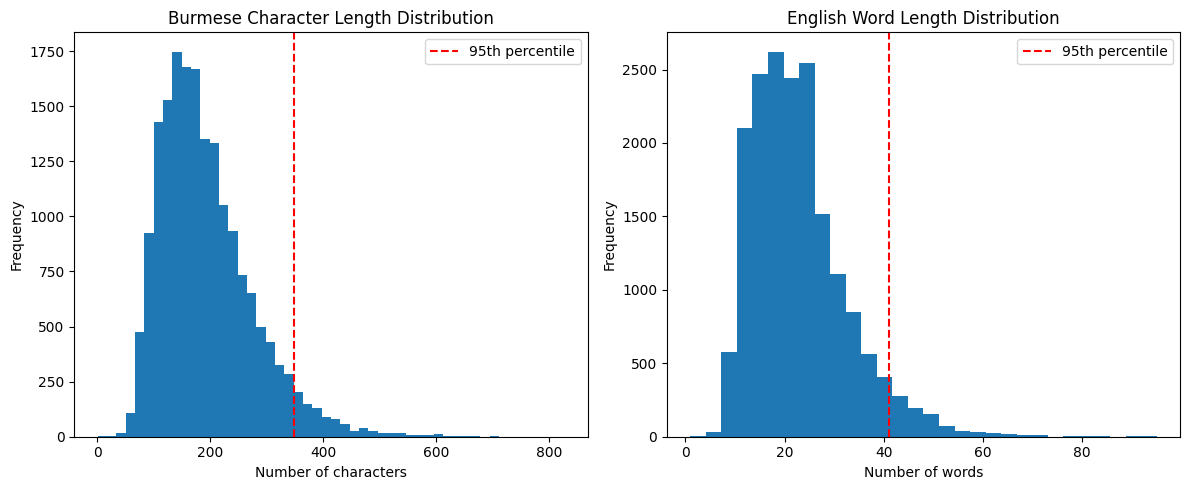

In [259]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

burmese_lengths = [len(list(item['translation']['burmese'])) for item in train_dataset]
# For English word lengths
english_lengths = [len(item['translation']['english'].split()) for item in train_dataset]

# Calculate percentiles
percentiles = [50, 75, 90, 95, 98, 99]
burmese_stats = {p: np.percentile(burmese_lengths, p) for p in percentiles}
english_stats = {p: np.percentile(english_lengths, p) for p in percentiles}

print("Burmese character length statistics:")
for p, v in burmese_stats.items():
    print(f"{p}th percentile: {v:.1f}")

print("\nEnglish word length statistics:")
for p, v in english_stats.items():
    print(f"{p}th percentile: {v:.1f}")

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(burmese_lengths, bins=50)
plt.title('Burmese Character Length Distribution')
plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.axvline(burmese_stats[95], color='r', linestyle='--', label='95th percentile')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(english_lengths, bins=30)
plt.title('English Word Length Distribution')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.axvline(english_stats[95], color='r', linestyle='--', label='95th percentile')
plt.legend()

plt.tight_layout()
plt.show()

tra

tra

In [ ]:
# Create tokenizers
src_tokenizer = create_burmese_tokenizer(train_dataset, config)
tgt_tokenizer = create_english_tokenizer(train_dataset, config)

# Function to inspect tokenization
def inspect_tokenization(text, tokenizer, is_character_level=True):
    encoded = tokenizer.encode(text)
    tokens = encoded.tokens
    ids = encoded.ids
    
    print(f"Original text: {text}")
    print(f"Tokenized into {len(tokens)} tokens:")
    
    # Print each token and its ID
    for i, (token, id) in enumerate(zip(tokens, ids)):
        print(f"  {i+1}. '{token}' → ID: {id}")
    
    # For character tokenization, verify each character
    if is_character_level:
        print("\nCharacter by character verification:")
        for i, char in enumerate(text):
            if i < len(tokens):
                print(f"  Character '{char}' → Token '{tokens[i]}'")
            else:
                print(f"  Character '{char}' → Not tokenized!")

# Inspect a few examples
burmese_samples = [train_dataset['translation'][i]['burmese'] for i in range(3)]
english_samples = [train_dataset['translation'][i]['english'] for i in range(3)]

for i, (bur, eng) in enumerate(zip(burmese_samples, english_samples)):
    print(f"\n=== Sample {i+1} ===")
    print("BURMESE TOKENIZATION (Character-level):")
    inspect_tokenization(bur, src_tokenizer, is_character_level=True)
    print("\nENGLISH TOKENIZATION (Word-level):")
    inspect_tokenization(eng, tgt_tokenizer, is_character_level=False)
    print("\n" + "="*50)

## Inference Code

In [278]:
import torch
from pathlib import Path
import math

# Load the model and tokenizers
def load_model_for_inference(model_path, config):
    print(model_path)
    # Load tokenizers
    src_tokenizer = Tokenizer.from_file("tokenizer_my")
    tgt_tokenizer = Tokenizer.from_file("tokenizer_en")
    
    
    # Create a new model with the same configuration
    model = build_transformer(
        src_vocab_size=src_tokenizer.get_vocab_size(),
        tgt_vocab_size=tgt_tokenizer.get_vocab_size(),
        src_seq_len=config['src_seq_len'],
        tgt_seq_len=config['tgt_seq_len'],
        d_model=config['d_model'],
        N=config['N'],
        h=config['h'],
        dropout=config['dropout'],
        d_ff=config['d_ff']
    )
    
    # Load the saved weights
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict['model_state_dict'])
    
    # Set model to evaluation mode
    model.eval()
    
    return model, src_tokenizer, tgt_tokenizer

# Function for translation
def translate(model, src_text, src_tokenizer, tgt_tokenizer, config, device):
    # Tokenize the source text
    encoder_input = src_tokenizer.encode(src_text).ids
    
    # Add SOS, EOS and padding tokens
    sos_token = src_tokenizer.token_to_id('[SOS]')
    eos_token = src_tokenizer.token_to_id('[EOS]')
    pad_token = src_tokenizer.token_to_id('[PAD]')
    
    # Ensure we don't exceed the maximum sequence length
    if len(encoder_input) > config['src_seq_len'] - 2:
        encoder_input = encoder_input[:config['src_seq_len'] - 2]
    
    # Calculate padding
    num_padding = config['src_seq_len'] - len(encoder_input) - 2
    
    # Create encoder input tensor
    encoder_input = torch.cat([
        torch.tensor([sos_token], dtype=torch.int64),
        torch.tensor(encoder_input, dtype=torch.int64),
        torch.tensor([eos_token], dtype=torch.int64),
        torch.tensor([pad_token] * num_padding, dtype=torch.int64)
    ], dim=0).unsqueeze(0).to(device)  # Add batch dimension
    
    # Create encoder mask
    encoder_mask = (encoder_input != pad_token).unsqueeze(0).unsqueeze(0).int().to(device)
    
    # Use greedy decoding for translation
    translation_tokens = greedy_decode(
        model=model,
        source=encoder_input,
        source_mask=encoder_mask,
        src_tokenizer=src_tokenizer,
        tgt_tokenizer=tgt_tokenizer,
        tgt_seq_len=config['tgt_seq_len'],
        device=device
    )
    
    # Decode the output tokens to text
    translation = tgt_tokenizer.decode(translation_tokens.detach().cpu().numpy())
    
    return translation

# Example usage
    # Load configuration
config = get_config()

# Select which model to use (e.g., the last epoch)
model_path = get_weights_file_path(config, 19)  # Use model from epoch 19

# Determine device
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# Load model and tokenizers
model, src_tokenizer, tgt_tokenizer = load_model_for_inference(model_path, config)
model = model.to(device)

# Example Burmese text for translation
burmese_text = "မင်္ဂလာပါ"

# Translate
translation = translate(model, burmese_text, src_tokenizer, tgt_tokenizer, config, device)

# Print results
print(f"Source (Burmese): {burmese_text}")
print(f"Translation (English): {translation}")

Using device: mps
weights/tmodel_19.pt
Source (Burmese): မင်္ဂလာပါ
Translation (English): The England include England .
